<center><h1>Методы Монте-Карло и машинное обучение</h1></center>

In [1]:
!python -V # Версия Python

Python 3.11.13


In [2]:
!pip install jupyterlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter-server 1.16.0
    Uninstalling jupyter-server-1.16.0:
      Successfully uninstalled jupyter-server-1.16.0
ERROR: pip's dependency resolver does not currently take into account all t

In [3]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

### Импорт необходимых библиотек
import os
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import sklearn
import scipy
import seaborn as sns
import jupyterlab as jlab
import ipywidgets
import random

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from scipy.stats import uniform

In [4]:
### Версии необходимых библиотек
packages = [
    "Torch", "NumPy", "Polars", "Matplotlib", "Seaborn", "Pandas", "Scikit-learn", "Scipy", "Ipywidgets", "JupyterLab"
]
# packages = [
#     "Torch", "NumPy", "Polars", "Matplotlib", "Seaborn", "Pandas", "Scikit-learn", "Scipy", "Ipywidgets"
# ]

package_objects = [
    torch, np, pl, mpl, sns, pd, sklearn, scipy, ipywidgets, jlab
]
# package_objects = [
#     torch, np, pl, mpl, sns, pd, sklearn, scipy, ipywidgets
# ]

versions = list(map(lambda obj: obj.__version__, package_objects))

columns_order = ["№", "Библиотека", "Версия"]
df_pkgs = (
    pl.DataFrame({
        columns_order[1]: packages,
        columns_order[2]: versions
    })
    .with_columns(pl.arange(1, pl.lit(len(packages)) + 1).alias(columns_order[0]))
    .select(columns_order)
)

display(df_pkgs)

path2reqs = "."
reqs_name = "requirements.txt"

def get_packages_and_versions():
    """Генерация строк с библиотеками и их версиями в формате: библиотека==версия"""

    for package, version in zip(packages, versions):
        yield f"{package.lower()}=={version}\n"

with open(os.path.join(path2reqs, reqs_name), "w", encoding = "utf-8") as f:
    f.writelines(get_packages_and_versions())

№,Библиотека,Версия
i64,str,str
1,"""Torch""","""2.6.0+cu124"""
2,"""NumPy""","""2.0.2"""
3,"""Polars""","""1.21.0"""
4,"""Matplotlib""","""3.10.0"""
5,"""Seaborn""","""0.13.2"""
6,"""Pandas""","""2.2.2"""
7,"""Scikit-learn""","""1.6.1"""
8,"""Scipy""","""1.15.3"""
9,"""Ipywidgets""","""7.7.1"""


# Лекция 2

## Методы Монте-Карло для интеграции и оценки

### Применение методов Монте-Карло для численного интегрирования

Методы Монте-Карло являются полезным инструментом для численного интегрирования, особенно при работе с многомерными интегралами, где традиционные методы становятся неэффективными.

#### Основной принцип метода Монте-Карло

Для вычисления определенного интеграла функции $f(x)$ на интервале $[a, b]$, метод Монте-Карло использует следующее приближение:

$$
I \approx (b - a) \times \frac{1}{N} \sum_{i=1}^{N} f(x_i)
$$

где:
- $I$ — приближенное значение интеграла
- $N$ — количество случайных точек
- $x_i$ — случайные точки, равномерно распределенные на интервале $[a, b]$

Этот метод особенно полезен при интегрировании функций в пространствах с высокой размерностью ($d > 3$).

#### Интуитивное объяснение

1. Берем $N$ случайных точек на интервале $[a, b]$
2. Вычисляем значение функции $f(x_i)$ для каждой точки
3. Находим среднее значение функции и умножаем его на длину интервала $b - a$

Чем больше точек $N$, тем точнее будет приближение

#### Интуитивные примеры

**1. Найти площадь прямоугольника с неровным дном, где функция $f(x)$ задает форму дна:**

1. Кидается на дно $N$ случайных камушков внутрь прямоугольника. Каждая точка $x_i$ определяется случайным образом в интервале $[a, b]$
2. Находится среднее значение высоты $f(x)$ в местах, где камушки приземлились. Средняя высота — это приближенная оценка функции на этом интервале.
3. Cредняя высота умножается на ширину прямоугольника $(b - a)$, для получения приближенного значения площади

Данный и последующие примеры показывают, как случайность может помочь решать задачи, которые сложны для аналитического решения.

In [5]:
# Установка seed для воспроизводимости результатов
random.seed(42)

# Функция f(x), задающая форму дна
def f(x):
    return x**2 + 1 # Пример функции

# Параметры интервала [a, b]
# a: Начальная точка интервала (начало измерения длины прямоугольника)
# b: Конечная точка интервала (длина прямоугольника)
a, b = 0, 10 # Границы интервала

# Количество случайных точек для метода Монте-Карло
N = 10000 # Чем больше точек, тем точнее результат

# Генерация случайных точек в интервале [a, b]
x_random = [random.uniform(a, b) for _ in range(N)]

# Вычисление значений функции в случайных точках
f_values = [f(x) for x in x_random]

# Среднее значение функции (средняя высота)
average_height = sum(f_values) / N

# Приближенная площадь (ширина интервала умножается на среднюю высоту)
area = (b - a) * average_height

print(f"Приближенная площадь методом Монте-Карло: {area:.4f}")

Приближенная площадь методом Монте-Карло: 343.0104


In [6]:
# Установка seed для воспроизводимости результатов
random.seed(42)

# Функция f(x), задающая форму дна
def f(x):
    return x**2 + 1 # Пример функции

# Параметры интервала [a, b]
# a: Начальная точка интервала (начало измерения длины прямоугольника)
# b: Конечная точка интервала (длина прямоугольника)
a, b = 0, 10 # Границы интервала

# Количество случайных точек для метода трапеций
N = 100

# Разбиение интервала
x_values = [a + i * (b - a) / N for i in range(N + 1)]
f_values = [f(x) for x in x_values]

# Метод трапеций (для простых функций быстрее сходится к точному решению, но не применить для сложных и многомерных задач)
area = 0

for i in range(N):
    area += 0.5 * (f_values[i] + f_values[i + 1]) * (x_values[i + 1] - x_values[i])

print(f"Площадь методом трапеций: {area:.4f}")

Площадь методом трапеций: 343.3500


**2. Для задачи компьютерного зрения рассчитать освещенность на поверхности используя симуляцию освещения и затенения в визуальных сценах. Предположим, что яркость на плоскости $[0, 1] \times [0, 1]$ описывается функцией:**

$$
f(x, y) = x^2 + y^2
$$

где:
- $x$ и $y$ — координаты точки
- $f(x, y)$ — интенсивность света, зависящая от расстояния точки до начала координат

Найти общую освещенность на данной плоскости, то есть:

$$
I = \int_0^1 \int_0^1 \left( x^2 + y^2 \right) \, dx \, dy
$$

In [7]:
# Параметры
a, b = 0, 1 # Границы площади
N = 100000 # Количество случайных точек

# Функция интенсивности света
def light_intensity(x, y):
    return x**2 + y**2

# Генерация случайных точек в области [0, 1] x [0, 1]
x_random = np.random.uniform(a, b, N)
y_random = np.random.uniform(a, b, N)

# Вычисление значений функции освещённости в случайных точках
intensities = light_intensity(x_random, y_random)

# Приближенный интеграл (метод Монте-Карло)
area = (b - a)**2  # Площадь области
total_light = area * np.mean(intensities)

print(f"Общая освещенность методом Монте-Карло: {total_light:.4f}")

Общая освещенность методом Монте-Карло: 0.6676


Численное интегрирование

In [8]:
from scipy.integrate import dblquad

# Функция интенсивности света
def light_intensity_exact(x, y):
    return x**2 + y**2

# Численное интегрирование с использованием Scipy
exact_light, _ = dblquad(light_intensity_exact, a, b, lambda x: a, lambda x: b)
print(f"Общая освещенность (точное значение): {exact_light:.4f}")

Общая освещенность (точное значение): 0.6667


Адаптация примера к 3D-графике:

1. Геометрия сцены (в реальных задачах освещения площадь $[0, 1] \times [0, 1]$ заменяется на более сложную геометрию сцены. Это могут быть поверхности, заданные как:
    - Полигональная сетка (треугольники или другие элементы)
    - Аналитические поверхности (сферы и т.д.)
    - Задание областей через неявные функции (например, $f(x, y, z) = 0$).
2. Сложные функции освещения:
Функция $f(x, y, z)$ может учитывать:
    - Положение источников света (расстояние от точки до источника света, угасание интенсивности)
    - Угол падения света (интенсивность света уменьшается с увеличением угла между нормалью поверхности и направлением на источник)
    - Свойства материала (отражательная способность, преломление и рассеивание света)

Пример сложной функции освещения:

$$
f(x, y, z) = L(x, y, z) \times \cos(\theta) \times R(x, y, z)
$$

где:
- $L(x, y, z)$ — интенсивность света от источника
- $\cos(\theta)$ — угол между нормалью и направлением света
- $R(x, y, z)$ — отражательная способность материала

3. Оптимизация (метод Монте-Карло используется в высокоразмерных пространствах), например:
    - Глобальное освещение (учет всех источников света, теней и их взаимодействий)
    - Расчет трассировки лучей (симуляция отражения, преломления и рассеивания)

Преимущества метода Монте-Карло перед `dblquad`

| **Метод** | **Преимущества** | **Недостатки** |
|-----------|------------------|----------------|
| **Метод Монте-Карло** | - Легко применим к сложным геометриям и функциям<br>- Подходит для высокоразмерных задач (например, 3D)<br>- Может учитывать стохастические процессы (шум, вероятностные источники света) | - Требует большого количества точек для высокой точности<br>- Результат является статистическим (среднее значение), что требует повторений для снижения ошибки |
| **`dblquad`** | - Высокая точность для двумерных интегралов.<br>- Легкость применения для аналитических функций | - Ограничен низкими размерами (2D и 3D)<br>- Плохо масштабируется для сложных геометрий<br>- Не справляется с функциями, имеющими разрывы или шум |

Метод Монте-Карло лучше подходит для задач, где:
1. **Высокая размерность** (более 2-3 измерений)
2. **Сложные функции** (сильно изменяющиеся или неаналитические функции)
3. **Реальная геометрия сцены** (полигональные или аналитически сложные поверхности)
4. **Глобальное освещение** (Учет множества источников света и их взаимодействий)

In [9]:
# Параметры
N = 10000 # Количество случайных точек

# Генерация случайных точек
x_random = np.random.uniform(0, 1, N)
y_random = np.random.uniform(0, 1, N)

# Определение точек внутри круга
inside_circle = x_random**2 + y_random**2 <= 1

# Оценка числа π
pi_estimate = 4 * np.sum(inside_circle) / N
print(f"Приближённое значение π: {pi_estimate:.6f}")

# Точное значение π для сравнения
from math import pi
print(f"Точное значение π: {pi:.6f}")

Приближённое значение π: 3.161600
Точное значение π: 3.141593


**3. Моделирование задач радиопередачи с использованием метода Монте-Карло**. Есть радиопередатчик, который может передавать сигнал в пределах определенного радиуса $R$. Не все переданные сигналы могут попасть в эту зону. **Задача** - найти, какая доля сигналов попадает в область действия радиопередатчика.

**Абстракция**
Аналогия с кругом (область действия радиопередатчика можно представить как круг радиуса $R$, расположенный внутри квадрата со сторонами длиной $R$. С помощью метода Монте-Карло возможно:
1. Генерировать случайные точки, представляющие переданные сигналы
2. Проверять, попадают ли точки в круг (область действия передатчика)
3. Оценивать вероятность попадания сигнала в зону действия

**Более ясно**
Представим, что радиопередатчик — это фонарик, а его луч света создает круг. Случайным образом кидаем камушки, где находится этот круг. Если камушек попал в круг, значит, он в зоне света. Наша цель — посчитать, сколько камушков оказалось в круге по сравнению с общим количеством.

In [10]:
import random

# Установка seed для воспроизводимости результатов
random.seed(42)

# Параметры задачи
R = 1 # Радиус действия радиопередатчика
N = 10000 # Количество переданных сигналов

# Счётчик сигналов, попавших в зону действия
inside_circle = 0

# Генерация случайных сигналов
for _ in range(N):
    # Случайное положение сигнала в квадрате [0, R] x [0, R]
    x, y = random.uniform(0, R), random.uniform(0, R)

    # Проверка, попал ли сигнал в круг с центром (0, 0) и радиусом R
    if x**2 + y**2 <= R**2:
        inside_circle += 1

# Оценка вероятности попадания сигнала в зону действия
coverage_ratio = inside_circle / N

print(f"Доля сигналов в зоне действия: {coverage_ratio:.6f}")

Доля сигналов в зоне действия: 0.781500


**Математическое объяснение результата**

1. **Геометрия задачи**
   - Моделируется радиопередатчик как круг радиуса $R = 1$, расположенный внутри квадрата с размерами $1 \times 1$. То есть, площадь квадрата равна $1 \times 1 = 1$, а площадь круга равна $\pi R^2 = \pi \times 1^2 = \pi$
2. **Отношение площадей**
   - Площадь круга, которая описывает зону действия радиопередатчика, составляет примерно $3.1416$ (это значение числа $\pi$)
   - Площадь квадрата равна $1$
3. **Частота попадания точек в круг**
   - Метод Монте-Карло генерирует случайные точки внутри квадрата. Если точка лежит внутри круга, то она считается попавшей в зону действия
   - Чем больше точек генерируется, тем точнее будет наша оценка отношения площадей
4. **Пояснение к числу 0.78..**
   - Идея заключается в том, что вероятность попадания точки в круг будет равна отношению площади круга к площади квадрата. Это отношение равно $\frac{\pi}{4}$
   - В данном случае это примерно $\frac{3.1416}{4} = 0.7854$
   - Так как были сгенерированы случайные точки и подсчитана их доля, на выходе получается приближенное значение, которое близко к $0.7854$, но может немного отличаться из-за случайности

### Применение методов Монте-Карло для оценки функции правдоподобия

#### Что такое функция правдоподобия?

Функция правдоподобия $L(\theta)$ — это функция, которая помогает оценить, насколько хорошо параметры модели $\theta$ объясняют наблюдаемые данные. Она играет очень важную роль в статистике и машинном обучении, поскольку позволяет находить такие параметры модели, которые с наибольшей вероятностью объясняют данные. Представим, что есть некоторый набор данных $D = \{x_1, x_2, \dots, x_N\}$, и хотим узнать, как параметр модели $\theta$ может влиять на эти данные. Функция правдоподобия показывает, с какой вероятностью можно было бы получить эти данные при заданном параметре $\theta$.

#### Математическое представление

Если есть набор данных $D$, состоящий из $N$ независимых наблюдений, то функция правдоподобия $L(\theta)$ для параметра $\theta$ может быть записана как:

$$
L(\theta) = P(D \mid \theta) = \prod_{i=1}^{N} P(x_i \mid \theta)
$$

Это означает, что вероятность всех наблюдений $x_1, x_2, \dots, x_N$, учитывая параметр $\theta$, равна произведению вероятностей каждого из этих наблюдений $P(x_i \mid \theta)$

#### Проблема с вычислением функции правдоподобия

В реальной жизни аналитическое вычисление функции правдоподобия часто бывает сложным или невозможным. Иногда нужно работать с очень сложными моделями, для которых вычисление вероятности каждого наблюдения становится трудоемким

#### Как решается эта проблема с помощью Монте-Карло?

Методы Монте-Карло — это подходы, основанные на случайных выборках, которые помогают решить задачу приближенного вычисления сложных математических выражений, таких как функция правдоподобия.

**Пример:** есть модель с параметром $\theta$, и нам нужно оценить, насколько вероятно, что наблюдаемые данные могут быть получены с этим параметром. Вместо того чтобы пытаться вычислить правдоподобие напрямую, мы можем использовать случайные выборки, чтобы оценить это правдоподобие

#### Как это работает?

1. **Генерируются случайные значения для параметра $\theta$**
2. **Для каждого случайного $\theta$** генерируются новые `предсказания` (или `симуляции`) $x_1, x_2, \dots, x_N$ на основе модели с этим параметром
3. **Вычисляется вероятность** того, что наблюдаемые данные $D$ будут близки к сгенерированным данным для каждого $\theta$
4. **Среднее значение этих вероятностей** дает приближенную оценку правдоподобия

#### Пример задачи

Есть набор данных, который описывает, как часто люди посещают спортзал в неделю. Предполагается, что частота посещений может следовать нормальному распределению, но не знаем точно параметры этого распределения (среднее и стандартное отклонение).

#### Как можно использовать метод Монте-Карло для оценки правдоподобия?

Необходимо оценить правдоподобие для нормального распределения с неизвестными параметрами $\mu$ (среднее) и $\sigma$ (стандартное отклонение). Для этого необходимо сгенерировать случайные выборки данных с параметрами $\mu$ и $\sigma$, и вычислить, насколько близки эти данные к наблюдениям. Среднее значение этих правдоподобий даст приближенную оценку.

#### Интуитивные примеры

**1. Оценить правдоподобие для задачи линейной регрессии.** Имеется набор данных, который необходимо использовать для линейной регрессии. Цель — оценить правдоподобие параметров модели (наклон и смещение) с использованием метода Монте-Карло.

Данная задача рассматривается, как линейная регрессия:

$$
y = \theta_0 + \theta_1 x + \epsilon
$$

где:
- $\epsilon$ — случайная ошибка с нормальным распределением

Среднее правдоподобие: -18483.69958501549


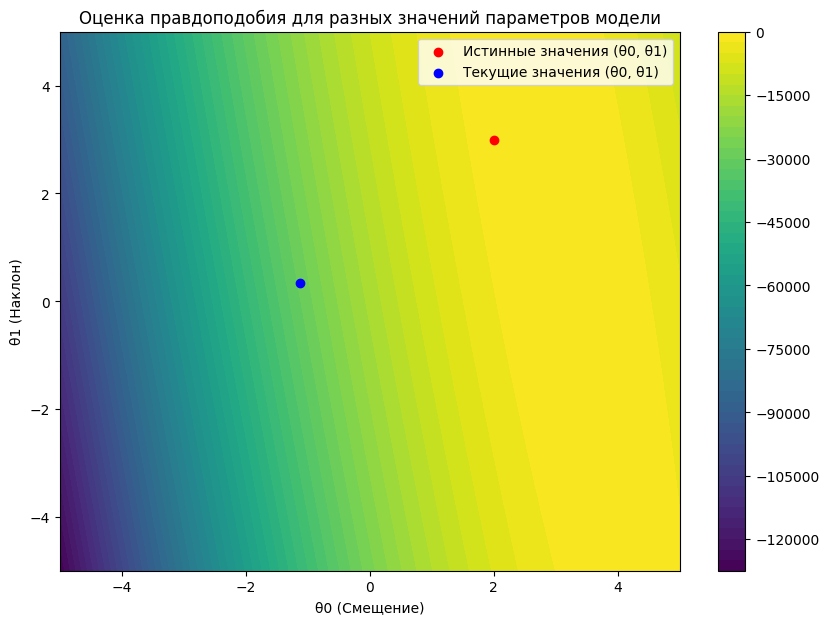

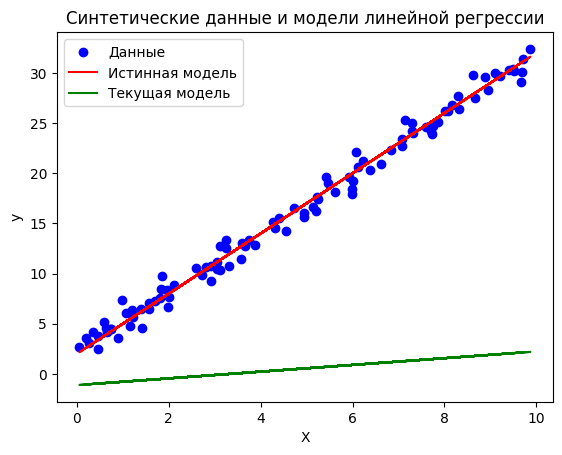

In [11]:
# Генерация синтетических данных
np.random.seed(42)

n_samples = 100 # Количество примеров
X = np.random.rand(n_samples, 1) * 10 # Случайные данные X в пределах от 0 до 10
true_theta_0 = 2 # Истинное смещение
true_theta_1 = 3 # Истинный наклон
y = true_theta_0 + true_theta_1 * X + np.random.randn(n_samples, 1) # Линейная зависимость с шумом

# Преобразование данных в тензоры для PyTorch
X_tensor = torch.tensor(X, dtype = torch.float32)
y_tensor = torch.tensor(y, dtype = torch.float32)

# Инициализация случайных параметров модели
theta_0 = torch.randn(1, requires_grad=True) # Инициализация случайного смещения
theta_1 = torch.randn(1, requires_grad=True) # Инициализация случайного наклона
sigma = 1.0 # Стандартное отклонение ошибки (шум)

# Функция для вычисления правдоподобия
def likelihood(X, y, theta_0, theta_1, sigma):
    """Функция для вычисления правдоподобия

    :param X: Входные данные
    :param y: Целевые значения
    :param theta_0: Смещение (параметр модели)
    :param theta_1: Наклон (параметр модели)
    :param sigma: Стандартное отклонение ошибки (шум)
    :return: Значение правдоподобия

    """

    y_pred = theta_0 + theta_1 * X # Прогноз от линейной модели
    likelihood_value = -0.5 * torch.sum(((y - y_pred) / sigma) ** 2) # Правдоподобие

    return likelihood_value

# Метод Монте-Карло для оценки правдоподобия
n_samples_monte_carlo = 10000 # Количество выборок
likelihood_samples = [] # Список для хранения значений правдоподобия

# Генерация случайных выборок для параметров модели и вычисление правдоподобия
for _ in range(n_samples_monte_carlo):
    theta_0_sample = torch.randn(1, requires_grad=True) # Случайное смещение
    theta_1_sample = torch.randn(1, requires_grad=True) # Случайный наклон

    # Оценка правдоподобия для текущей выборки параметров
    likelihood_value = likelihood(X_tensor, y_tensor, theta_0_sample, theta_1_sample, sigma)
    likelihood_samples.append(likelihood_value.item())

# Вычисление среднего правдоподобия по всем выборкам
avg_likelihood = np.mean(likelihood_samples)
print(f"Среднее правдоподобие: {avg_likelihood}")

# Визуализация данных и модели
theta_0_values = np.linspace(-5, 5, 100) # Диапазон значений для смещения
theta_1_values = np.linspace(-5, 5, 100) # Диапазон значений для наклона
X_grid, Y_grid = np.meshgrid(theta_0_values, theta_1_values) # Создание сетки значений параметров
Z_grid = np.zeros_like(X_grid) # Массив для хранения значений правдоподобия

# Заполнение сетки значениями правдоподобия для каждого сочетания параметров
for i in range(len(theta_0_values)):
    for j in range(len(theta_1_values)):
        theta_0_sample = torch.tensor(theta_0_values[i], dtype = torch.float32)
        theta_1_sample = torch.tensor(theta_1_values[j], dtype = torch.float32)
        Z_grid[i, j] = likelihood(X_tensor, y_tensor, theta_0_sample, theta_1_sample, sigma).item()

# Визуализация контурного графика правдоподобия
plt.figure(figsize = (10, 7))
cp = plt.contourf(X_grid, Y_grid, Z_grid, 50, cmap = "viridis") # Контурный график правдоподобия
plt.colorbar(cp) # Добавление цветовой шкалы
plt.xlabel("θ0 (Смещение)") # Подпись для оси X
plt.ylabel("θ1 (Наклон)") # Подпись для оси Y
plt.title("Оценка правдоподобия для разных значений параметров модели") # Заголовок
plt.scatter(true_theta_0, true_theta_1, color='red', label='Истинные значения (θ0, θ1)') # Отображение истинных значений
plt.scatter(theta_0.item(), theta_1.item(), color='blue', label='Текущие значения (θ0, θ1)') # Отображение текущих значений
plt.legend()
plt.show()

# Визуализация данных и линейной модели
# График для данных и линейной модели с истинными параметрами
plt.scatter(X, y, label = "Данные", color = "blue") # Синие точки - данные
plt.plot(X, true_theta_0 + true_theta_1 * X, color = "red", label = "Истинная модель") # Истинная модель (красная линия)
plt.plot(X, theta_0.item() + theta_1.item() * X, color = "green", label = "Текущая модель") # Линия с текущими значениями
plt.xlabel("X") # Подпись для оси X
plt.ylabel("y") # Подпись для оси Y
plt.legend()
plt.title("Синтетические данные и модели линейной регрессии") # Заголовок
plt.show()

**Математическое объяснение результата**

1. **Генерация синтетических данных**, которые соответствуют линейной зависимости

$$
y = \theta_0 + \theta_1 \times X
$$

где:

- $X$ — это случайные значения
- $y$ — это целевые значения, полученные с добавлением шума

2. **Инициализация параметров модели** $\theta_0$ (смещение) и $\theta_1$ (наклон). Эти параметры используются для оценки модели

3. **Функция для вычисления правдоподобия.** Это мера того, насколько хорошо параметры модели $\theta_0$ и $\theta_1$ описывают данные. Правдоподобие вычисляется как разница между реальными значениями $y$ и предсказаниями модели с параметрами $\theta_0$ и $\theta_1$, подставленная в нормальное распределение ошибок

4. **Метод Монте-Карло** генерирует случайные выборки для параметров $\theta_0$ и $\theta_1$ (случайным образом подбираются параметры модели) и оценивается их правдоподобие для каждой выборки. Это позволяет получить распределение правдоподобия для разных значений параметров модели

5. **Визуализация**
    - **Контурный график правдоподобия** для отображения значения правдоподобия для различных значений параметров модели $\theta_0$ и $\theta_1$
    - **Линия для истинной модели и текущей модели** отображает истинные значения $\theta_0$ и $\theta_1$ на графике, а также текущие случайные параметры модели, чтобы увидеть, насколько они отличаются от истинных значений

**Почему это не обучение модели?**

Обычно обучение модели включает в себя **оптимизацию параметров**, например, с использованием градиентного спуска, чтобы минимизировать ошибку между предсказанными значениями и реальными значениями. В данном случае не оптимизируются параметры с помощью градиентного спуска, а происходит их оценка с использованием правдоподобия через метод Монте-Карло, генерируя случайные выборки для параметров модели. Это позволяет оценить параметры, но не обучать модель.

Для обучения модели с линейной регрессией можно использовать методы, такие как **градиентный спуск**, которые будут минимизировать ошибку предсказания, а не только оценивать параметры.

### Применение методов Монте-Карло для байесовских методов

Среднее правдоподобие (с использованием байесовского подхода): -18460.594167175674


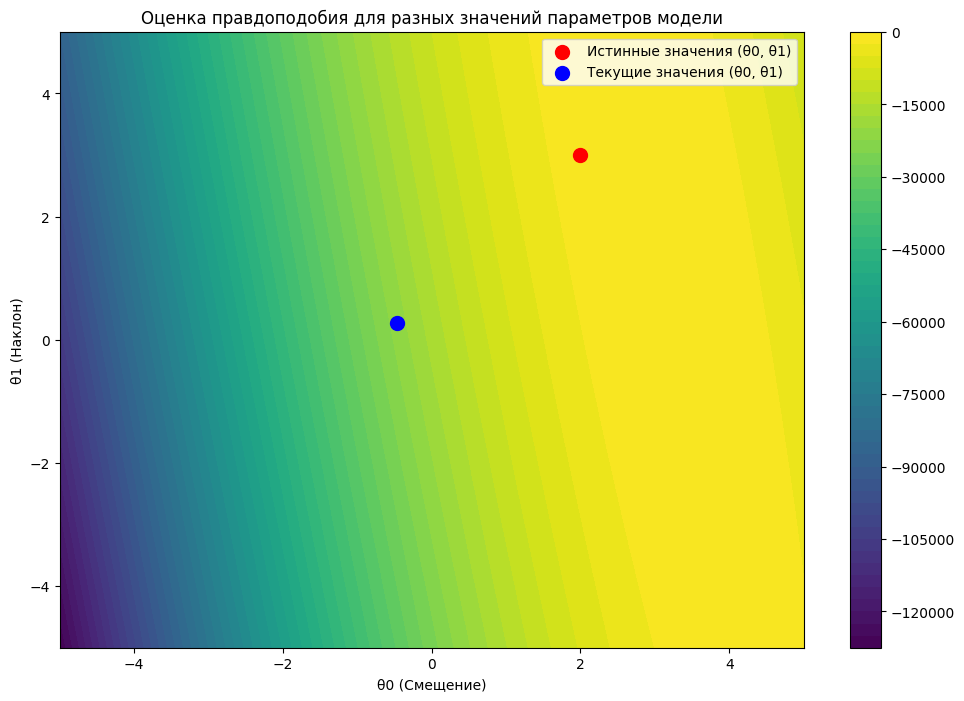

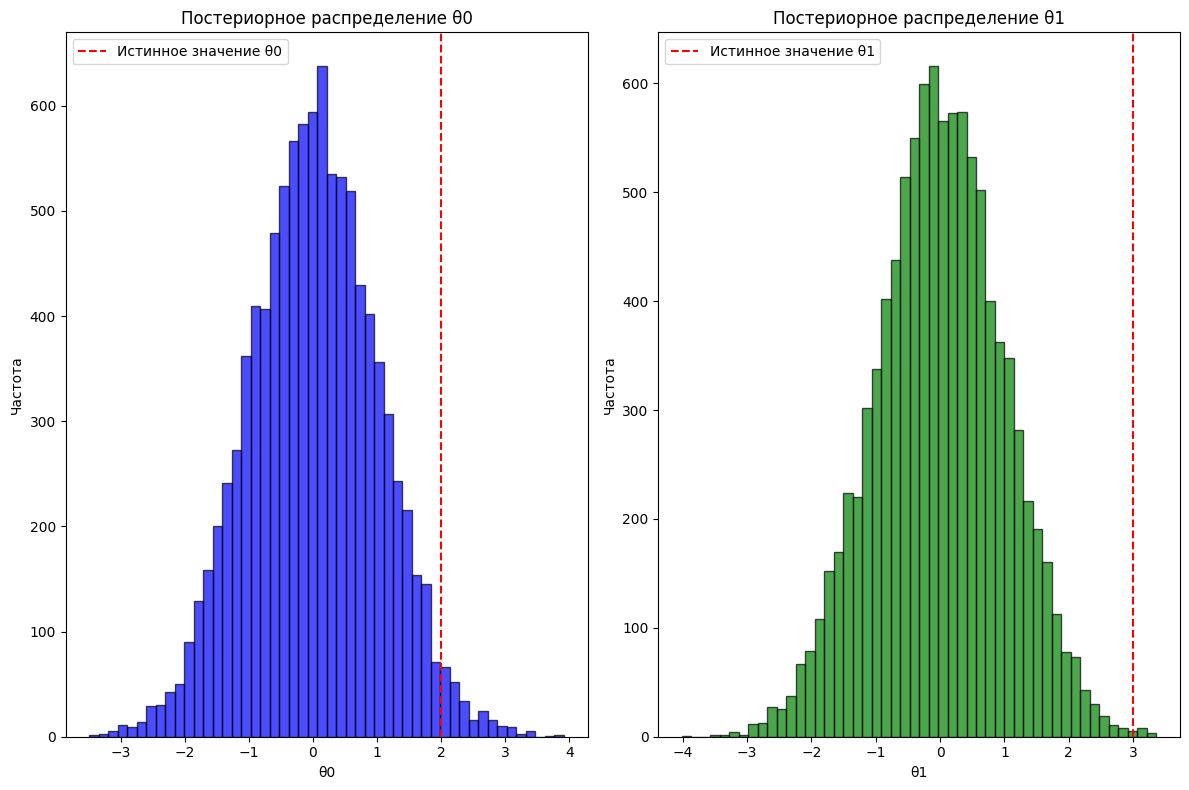

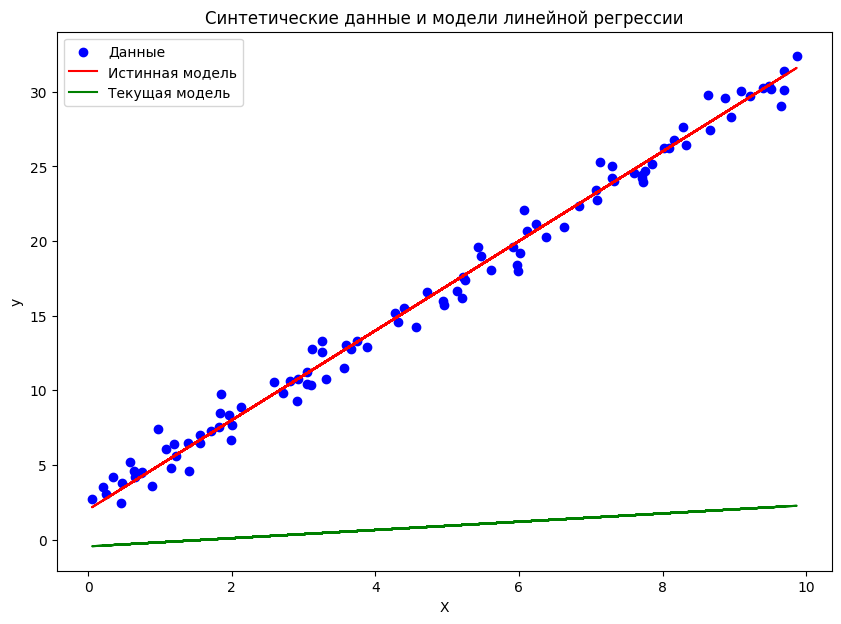

In [12]:
# Генерация синтетических данных
np.random.seed(42)
n_samples = 100 # Количество примеров
X = np.random.rand(n_samples, 1) * 10 # Случайные данные X в пределах от 0 до 10
true_theta_0 = 2 # Истинное смещение
true_theta_1 = 3 # Истинный наклон
y = true_theta_0 + true_theta_1 * X + np.random.randn(n_samples, 1) # Линейная зависимость с шумом

# Преобразуем данные в тензоры для PyTorch
X_tensor = torch.tensor(X, dtype = torch.float32)
y_tensor = torch.tensor(y, dtype = torch.float32)

# Инициализация параметров модели
theta_0 = torch.randn(1, requires_grad = True) # Инициализация случайного смещения
theta_1 = torch.randn(1, requires_grad = True) # Инициализация случайного наклона
sigma = 1.0  # Стандартное отклонение ошибки (шум)

# Функция для вычисления правдоподобия
def likelihood(X, y, theta_0, theta_1, sigma):
    """Функция для вычисления правдоподобия

    :param X: Входные данные
    :param y: Целевые значения
    :param theta_0: Смещение (параметр модели)
    :param theta_1: Наклон (параметр модели)
    :param sigma: Стандартное отклонение ошибки (шум)
    :return: Значение правдоподобия
    """

    y_pred = theta_0 + theta_1 * X # Прогноз от линейной модели
    likelihood_value = -0.5 * torch.sum(((y - y_pred) / sigma) ** 2) # Правдоподобие
    return likelihood_value

# Важностное сэмплирование (метод Монте-Карло) для байесовского подхода
n_samples_monte_carlo = 10000 # Количество выборок
likelihood_samples = [] # Список для хранения значений правдоподобия
theta_0_samples = [] # Список для хранения выборок θ0
theta_1_samples = [] # Список для хранения выборок θ1

# Важностное сэмплирование: сэмплируем параметры с учетом априорного распределения
for i in range(n_samples_monte_carlo):
    theta_0_sample = torch.randn(1, requires_grad = True) # Случайное смещение
    theta_1_sample = torch.randn(1, requires_grad = True) # Случайный наклон

    # Вычисление правдоподобия для сэмплированных параметров
    likelihood_value = likelihood(X_tensor, y_tensor, theta_0_sample, theta_1_sample, sigma)

    # Оценка апостериорного распределения
    posterior_value = likelihood_value # Пропорционально правдоподобию

    # Сохранение выборок с весами
    likelihood_samples.append(posterior_value.item())
    theta_0_samples.append(theta_0_sample.item())
    theta_1_samples.append(theta_1_sample.item())

# Вычисление среднего правдоподобия по всем выборкам
avg_likelihood = np.mean(likelihood_samples)
print(f"Среднее правдоподобие (с использованием байесовского подхода): {avg_likelihood}")

# Визуализация контурного графика правдоподобия
theta_0_values = np.linspace(-5, 5, 100) # Диапазон значений для смещения
theta_1_values = np.linspace(-5, 5, 100) # Диапазон значений для наклона
X_grid, Y_grid = np.meshgrid(theta_0_values, theta_1_values) # Создание сетки значений параметров
Z_grid = np.zeros_like(X_grid) # Массив для хранения значений правдоподобия

# Заполнение сетки значениями правдоподобия для каждого сочетания параметров
for i in range(len(theta_0_values)):
    for j in range(len(theta_1_values)):
        theta_0_sample = torch.tensor(theta_0_values[i], dtype = torch.float32)
        theta_1_sample = torch.tensor(theta_1_values[j], dtype = torch.float32)
        Z_grid[i, j] = likelihood(X_tensor, y_tensor, theta_0_sample, theta_1_sample, sigma).item()

# Визуализация контурного графика правдоподобия
plt.figure(figsize = (12, 8))
cp = plt.contourf(X_grid, Y_grid, Z_grid, 50, cmap = "viridis") # Контурный график правдоподобия
plt.colorbar(cp) # Добавление цветовой шкалы
plt.xlabel("θ0 (Смещение)") # Подпись для оси X
plt.ylabel("θ1 (Наклон)") # Подпись для оси Y
plt.title("Оценка правдоподобия для разных значений параметров модели") # Заголовок
plt.scatter(true_theta_0, true_theta_1, color = "red", label = "Истинные значения (θ0, θ1)", s = 100, zorder = 5) # Истинные значения
plt.scatter(theta_0.item(), theta_1.item(), color = "blue", label = "Текущие значения (θ0, θ1)", s = 100, zorder = 5) # Текущие значения
plt.legend()
plt.show()

# Визуализация постериорных распределений параметров
plt.figure(figsize = (12, 8))

# Постериорное распределение для θ0
plt.subplot(1, 2, 1)
plt.hist(theta_0_samples, bins = 50, color = "blue", edgecolor = "black", alpha = 0.7)
plt.title("Постериорное распределение θ0")
plt.xlabel("θ0")
plt.ylabel("Частота")
plt.axvline(true_theta_0, color = "red", linestyle = "--", label = "Истинное значение θ0")
plt.legend()

# Постериорное распределение для θ1
plt.subplot(1, 2, 2)
plt.hist(theta_1_samples, bins = 50, color = "green", edgecolor = "black", alpha = 0.7)
plt.title("Постериорное распределение θ1")
plt.xlabel("θ1")
plt.ylabel("Частота")
plt.axvline(true_theta_1, color = "red", linestyle = "--", label = "Истинное значение θ1")
plt.legend()

plt.tight_layout()
plt.show()

# Визуализация данных и линейной модели
plt.figure(figsize = (10, 7))
# График для данных и линейной модели с истинными параметрами
plt.scatter(X, y, label = "Данные", color = "blue") # Синие точки - данные
plt.plot(X, true_theta_0 + true_theta_1 * X, color = "red", label = "Истинная модель") # Истинная модель (красная линия)
plt.plot(X, theta_0.item() + theta_1.item() * X, color = "green", label = "Текущая модель") # Линия с текущими значениями
plt.xlabel("X") # Подпись для оси X
plt.ylabel("y") # Подпись для оси Y
plt.legend()
plt.title("Синтетические данные и модели линейной регрессии") # Заголовок
plt.show()

**Математическое объяснение результата**

1. **Генерация синтетических данных**, которые следуют линейной зависимости

$$
y = \theta_0 + \theta_1 \times X
$$

где:

- $X$ — это случайные значения (входные данные)
- $y$ — это целевые значения (выходные данные), полученные с добавлением случайного шума, чтобы создать более реалистичные данные. Шум моделируется как нормально распределенная ошибка

2. **Инициализация параметров модели**
- $\theta_0$ — это смещение (или пересечение с осью $y$)
- $\theta_1$ — это наклон (или коэффициент наклона линии регрессии)

Процесс начинается с случайных значений для инициированных параметров. Однако в байесовском подходе важным моментом является не просто нахождение `лучших` значений для $\theta_0$ и $\theta_1$, а оценка того, с какой вероятностью эти параметры могут быть истинными, учитывая наблюдаемые данные

3. **Функция для вычисления правдоподобия**

В байесовской регрессии правдоподобие является ключевой концепцией. Это мера того, насколько хорошо параметры модели $\theta_0$ и $\theta_1$ соответствуют данным. Правдоподобие выражается как функция того, как хорошо предсказания соответствуют истинным данным

$$
\mathcal{L}(\theta_0, \theta_1) = P(y | X, \theta_0, \theta_1)
$$

Для линейной модели, ошибки (или отклонения между предсказанными значениями $y_{pred}$ и реальными значениями $y$) считаются нормально распределенными с параметром $\sigma$ (стандартное отклонение шума)

$$
\mathcal{L}(\theta_0, \theta_1) = -\frac{1}{2\sigma^2} \sum_{i=1}^n \left( y_i - (\theta_0 + \theta_1 \times X_i) \right)^2
$$

Это означает, что если параметры $\theta_0$ и $\theta_1$ приближаются к истинным значениям, правдоподобие увеличивается, и наоборот

4. **Метод Монте-Карло и важностное сэмплирование**

Метод Монте-Карло позволяет оценить интегралы и распределения, генерируя случайные выборки. В данном контексте производится сэмплирование параметров модели $\theta_0$ и $\theta_1$ из их априорного распределения (например, из нормального распределения) и вычисляется правдоподобие для каждой выборки. Это позволяет исследовать, как распределяются параметры, не полагаясь на фиксированные значения

Важностное сэмплирование используется для того, чтобы сэмплировать более часто те параметры, которые дают более высокое правдоподобие. Это позволяет  сосредоточиться на наиболее вероятных значениях параметров

5. **Визуализация**
- **Контурный график правдоподобия** показывает, как правдоподобие меняется в зависимости от значений параметров $\theta_0$ и $\theta_1$. Видно, что на графике есть области, где правдоподобие высоко, и области, где оно низкое. Истинные значения $\theta_0$ и $\theta_1$ находятся в точке, где правдоподобие максимально
- **Красная линия для истинной модели и текущей модели** отображает истинные параметры, а зеленая линия — текущие параметры модели. Можно видеть, как текущие параметры модели приближаются к истинным значениям, если метод Монте-Карло достаточно точно оценил их

**Почему это не обучение модели?**

В контексте этого подхода **обучение модели** отличается от традиционного. Обычно обучение включает в себя **оптимизацию параметров**, например, с использованием градиентного спуска, с целью минимизировать ошибку (например, среднеквадратичную ошибку) между предсказанными и реальными значениями.

Однако в байесовском подходе происходит стремление не к минимизации ошибки, а к оценке **распределения параметров**, учитывая вероятности. В итоге получается **оценка параметров**, которые лучше всего описывают данные, но не стремятся уменьшить ошибку между предсказаниями и реальными значениями с помощью алгоритма оптимизации, как это происходит в традиционном обучении.

Метод Монте-Карло используется для того, чтобы изучить, с какой вероятностью различные параметры могут быть истинными, что отличается от стандартной задачи оптимизации.

# Семинар 2

Точность модели: 97.37%
Отчет о классификации:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        43
           1       0.96      1.00      0.98        71

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



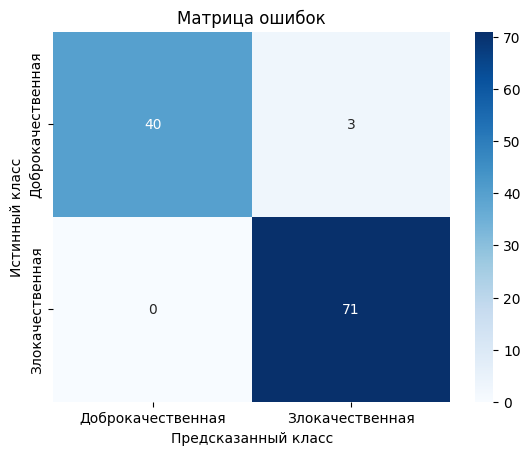

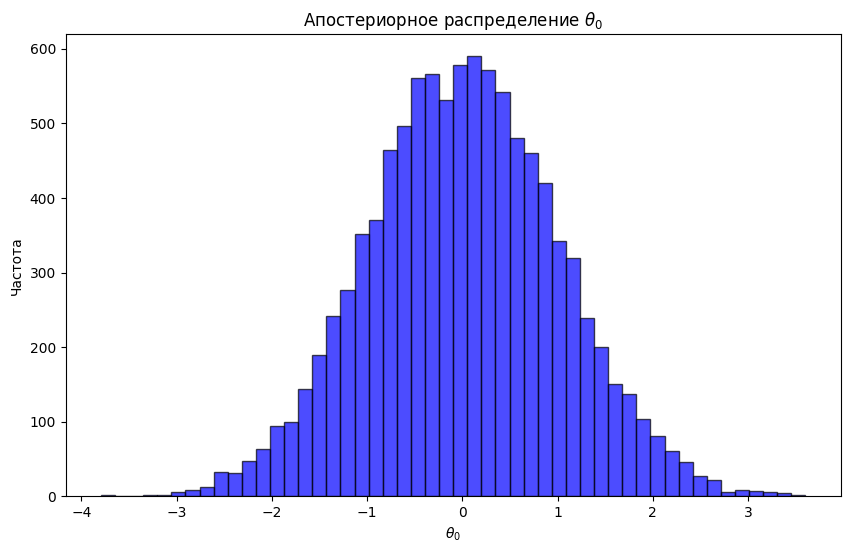

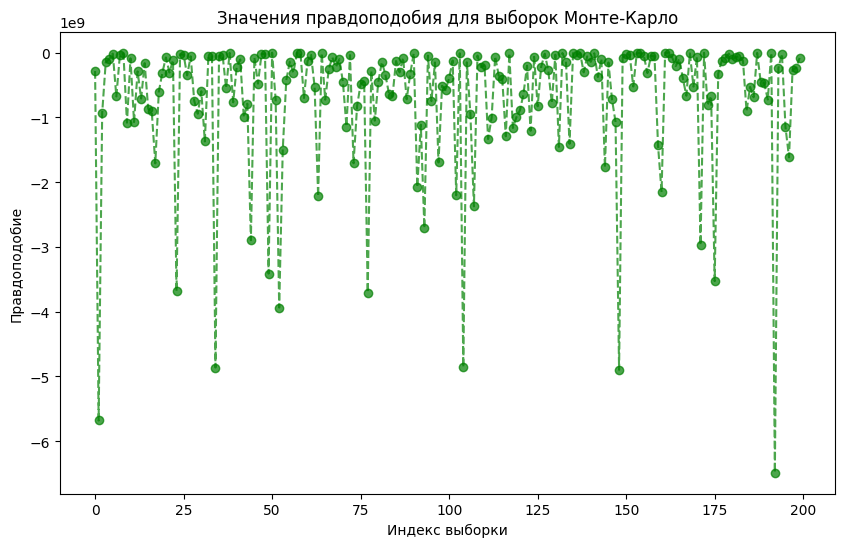

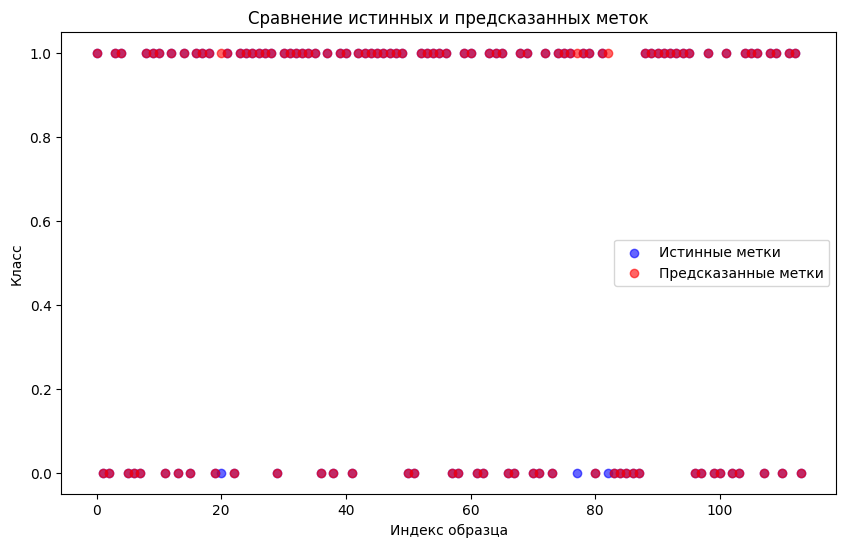

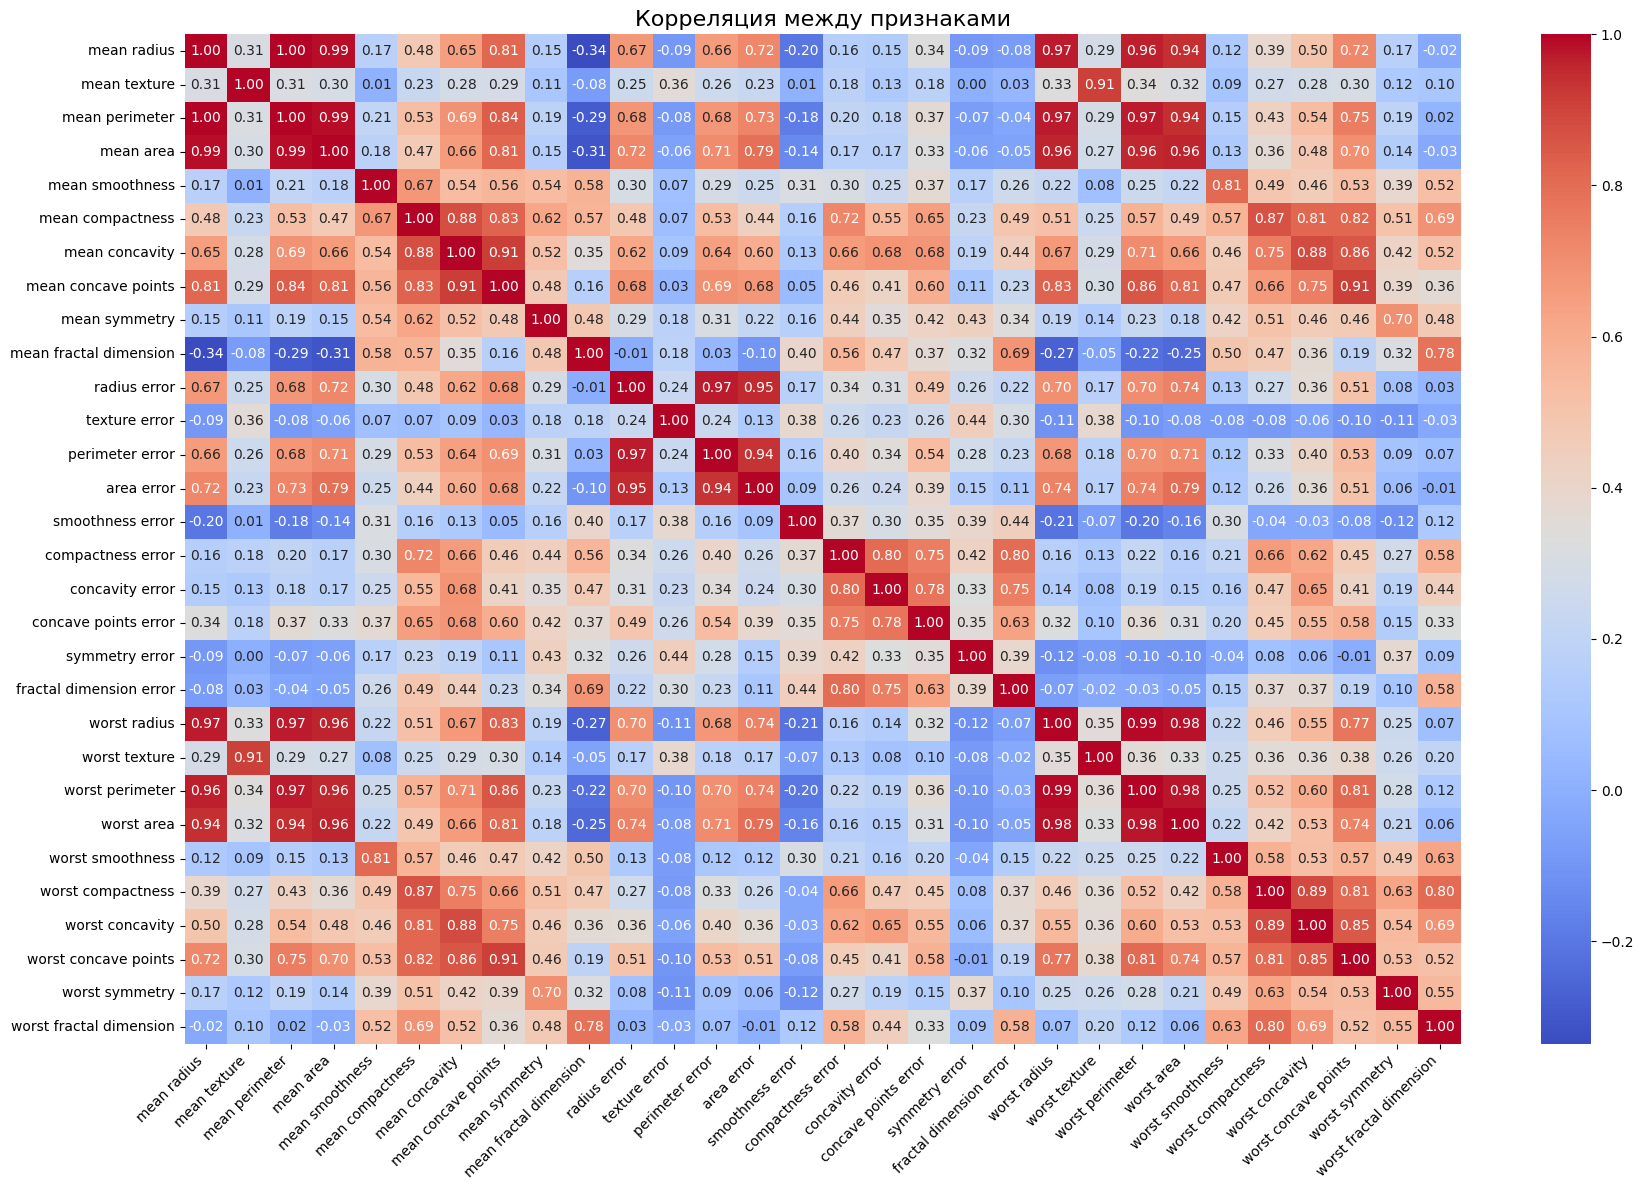

In [13]:
# Загрузка набора данных breast_cancer из sklearn
breast_cancer_data = load_breast_cancer(as_frame = True)
data = breast_cancer_data.data # Признаки (характеристики опухоли)
labels = breast_cancer_data.target # Метки классов (доброкачественная или злокачественная опухоль)

# Разделение данных на обучающую и тестовую выборки в соотношении 80/20
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 42)

# Применение наивного байесовского классификатора (инициализация и обучение модели Gaussian Naive Bayes)
model = GaussianNB()
model.fit(X_train, y_train)

# Прогнозирование на тестовых данных
y_pred = model.predict(X_test)

# Вычисление точности модели и вывод результата
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy * 100:.2f}%")

# Подробный отчет по классификации
print("Отчет о классификации:")
print(classification_report(y_test, y_pred))

# Визуализация результатов классификации
# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(
    conf_matrix, annot = True, fmt = "d", cmap = "Blues",
    xticklabels = ["Доброкачественная", "Злокачественная"],
    yticklabels = ["Доброкачественная", "Злокачественная"],
)
plt.title("Матрица ошибок")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.show()

# Метод Монте-Карло для оценки параметров модели
# Инициализация параметров
n_samples = 10000 # Число выборок
likelihoods = []
theta_samples = []

# Генерация случайных выборок для параметров модели
for _ in range(n_samples):
    theta_sample = np.random.randn(X_train.shape[1]) # Случайные параметры
    y_pred_sample = np.dot(X_train, theta_sample) # Линейная комбинация признаков
    likelihood = -np.sum((y_train - y_pred_sample) ** 2) # Правдоподобие как отрицательная ошибка
    theta_samples.append(theta_sample)
    likelihoods.append(likelihood)

# Преобразование списков в массивы для анализа
theta_samples = np.array(theta_samples)
likelihoods = np.array(likelihoods)

# Визуализация распределения первого параметра $\theta_0$
plt.figure(figsize = (10, 6))
plt.hist(theta_samples[:, 0], bins = 50, color = "blue", edgecolor = "black", alpha = 0.7)
plt.title("Апостериорное распределение $\\theta_0$")
plt.xlabel("$\\theta_0$")
plt.ylabel("Частота")
plt.show()

# Визуализация правдоподобия для первых 200 выборок
plt.figure(figsize = (10, 6))
plt.plot(likelihoods[:200], color = "green", marker = "o", linestyle = "dashed", alpha = 0.7)
plt.title("Значения правдоподобия для выборок Монте-Карло")
plt.xlabel("Индекс выборки")
plt.ylabel("Правдоподобие")
plt.show()

# Наглядное сравнение истинных и предсказанных классов
plt.figure(figsize = (10, 6))
plt.scatter(range(len(y_test)), y_test, color = "blue", label = "Истинные метки", alpha = 0.6)
plt.scatter(range(len(y_pred)), y_pred, color = "red", label = "Предсказанные метки", alpha = 0.6)
plt.title("Сравнение истинных и предсказанных меток")
plt.xlabel("Индекс образца")
plt.ylabel("Класс")
plt.legend()
plt.show()

# Дополнительные визуализации для лучшего понимания данных
# Визуализация корреляции между признаками в тренировочных данных
plt.figure(figsize = (18, 12)) # Увеличение размера графика
sns.heatmap(
    X_train.corr(), # Использование метода .corr() для вычисления корреляции
    annot = True, # Отображение значений внутри ячеек
    fmt = ".2f", # Формат значений
    cmap = "coolwarm", # Цветовая схема
    cbar = True, # Добавление цветовой шкалы
    xticklabels = X_train.columns, # Подписи по оси X
    yticklabels = X_train.columns # Подписи по оси Y
)
plt.title("Корреляция между признаками", fontsize = 16)
plt.xticks(rotation = 45, ha = "right", fontsize = 10) # Поворот подписей для лучшей читаемости
plt.yticks(fontsize = 10)
plt.tight_layout() # Подгонка элементов графика
plt.show()

**Анализ результатов классификации и метод Монте-Карло для оценки параметров модели**

1. **Загрузка и подготовка данных**
    - **Источник данных**: набор данных `breast_cancer` из библиотеки `sklearn`. Данные представляют собой признаки опухолей молочной железы, предназначенные для классификации на доброкачественные и злокачественные
    - **Признаки (`data`)**: представляют собой числовые значения, такие как размеры опухоли, текстура, симметрия и другие параметры
    - **Метки классов (`labels`)**: двоичные значения, где `0` — доброкачественная опухоль, `1` — злокачественная

Данные разделены на обучающую и тестовую выборки в соотношении 80/20

2. **Обучение наивного байесовского классификатора**
    - **Модель**: Gaussian Naive Bayes
    - **Процесс**: обучение модели на обучающей выборке, прогнозирование классов на тестовой выборке
3. **Метрики качества модели**
    - **Точность (accuracy)**: модель классифицировала 97.37% тестовых данных правильно
    - **Отчет о классификации**
       - `precision` (точность): доля истинных положительных классификаций среди всех предсказанных положительных
       - `recall` (полнота): доля истинных положительных классификаций среди всех фактических положительных
       - `f1-score`: гармоническое среднее точности и полноты
       - `support`: количество экземпляров каждого класса
4. **Визуализация результатов классификации**
    - **Матрица ошибок**:
       - Показывает распределение истинных и предсказанных классов
       - Выявляет, что большинство предсказаний правильные, с минимальным числом ошибок
5. **Сравнение истинных и предсказанных меток**
   - Синие точки — истинные метки
   - Красные точки — предсказанные метки
   - Почти полное совпадение между ними демонстрирует высокую точность модели
6. **Метод Монте-Карло**
    - Использован для анализа параметров модели и правдоподобия
    - **Генерация параметров**: случайные выборки параметров \(\theta\), представляющие веса признаков
    - **Правдоподобие**: оценено как отрицательная сумма квадратов ошибок между предсказанными и истинными значениями меток
7. **Результаты**
    - **Апостериорное распределение параметра \(\theta_0\)**
       - Построена гистограмма для первого параметра \(\theta_0\)
       - Помогает понять распределение значений параметра при случайной генерации
8. **Правдоподобие для первых 200 выборок**
    - График показывает изменения правдоподобия для случайных параметров
    - Используется для анализа устойчивости модели
9. **Визуализация корреляции признаков**
    - **Описание**
      - Построена тепловая карта корреляции между признаками
      - Подписи осей соответствуют названиям признаков (например, `mean radius`, `mean texture`)
    - **Наблюдения**
      - Высокая корреляция между определенными признаками указывает на их избыточность
      - Например, некоторые сильно коррелируют, что может привести к дублированию информации
10. **Выводы**
    - **Модель**
       - Gaussian Naive Bayes хорошо справляется с классификацией в данном наборе данных
       - Точность 97.37% подтверждается минимальным количеством ошибок
    - **Визуализация**
       - Матрица ошибок, графики правдоподобия и апостериорного распределения параметров предоставляют ценную информацию о работе модели
       - Тепловая карта корреляции помогает выявить признаки, которые можно исключить для упрощения модели
    - **Что еще?**
       - Удаление признаков с высокой корреляцией может упростить модель без потери точности
       - ...
11. **Дополнительно**
    - **Почему Gaussian Naive Bayes хорошо справляется с классификацией?**
        - **Gaussian Naive Bayes** (GNB) — это алгоритм, который используется для классификации данных. Он предполагает, что признаки данных независимы друг от друга и имеют нормальное распределение (гауссово). В данном примере модель работает хорошо по нескольким причинам:
            - **Нормальность признаков.** В наборе данных `breast_cancer` многие признаки (например, размеры опухоли или текстура) следуют нормальному распределению. Это делает алгоритм точным, так как он хорошо работает с такими данными
            - **Простота и скорость.** GNB — простой и быстрый алгоритм, который работает эффективно с небольшими наборами данных
            - **Отсутствие переобучения.** В данном примере, где есть только 30 признаков, GNB не страдает от переобучения и дает высокую точность
    - **Как понять результаты с помощью Матрицы ошибок, графиков правдоподобия и апостериорного распределения?**
        - **Матрица ошибок** помогает понять, сколько ошибок делает модель. Она показывает, сколько раз модель предсказала правильный класс (например, правильную опухоль) и сколько раз ошиблась
            - **Диагональ матрицы** показывает правильные предсказания. Чем больше значений на диагонали, тем точнее модель
            - **Остальные ячейки** показывают ошибки. Например, если модель предсказала `доброкачественная` вместо `злокачественная`, это попадет в одну из этих ячеек
        - **График правдоподобия** показывает, насколько хорошо модель оценивает свои параметры. Когда модель хорошо обучена, правдоподобие будет высоким
            - Если правдоподобие растет, это значит, что параметры модели лучше подходят к данным
            - Если правдоподобие скачет, это может указывать на проблемы с моделью
        - **Апостериорное распределение параметров** показывает, какие значения параметров модели наиболее вероятны
            - **Гистограмма параметра** показывает, где находятся наиболее вероятные значения параметра (например, для параметра \(\theta_0\))
            - **Ширина распределения.** Если гистограмма сужается, это значит, что модель уверена в своих параметрах. Если она широкая, то модель может быть менее уверена.

### Уменьшенный набор признаков

Точность модели на полном наборе признаков: 97.37%
Отчет о классификации для полной модели:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        43
           1       0.96      1.00      0.98        71

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



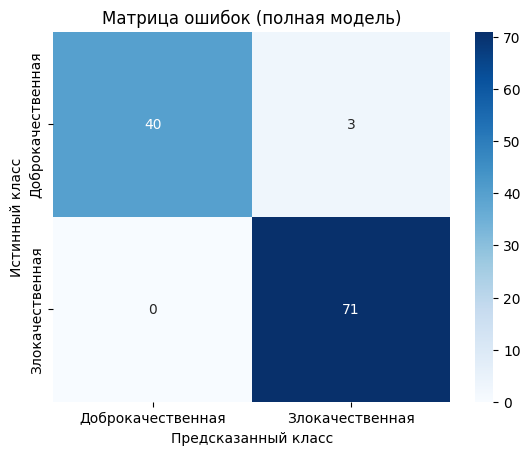

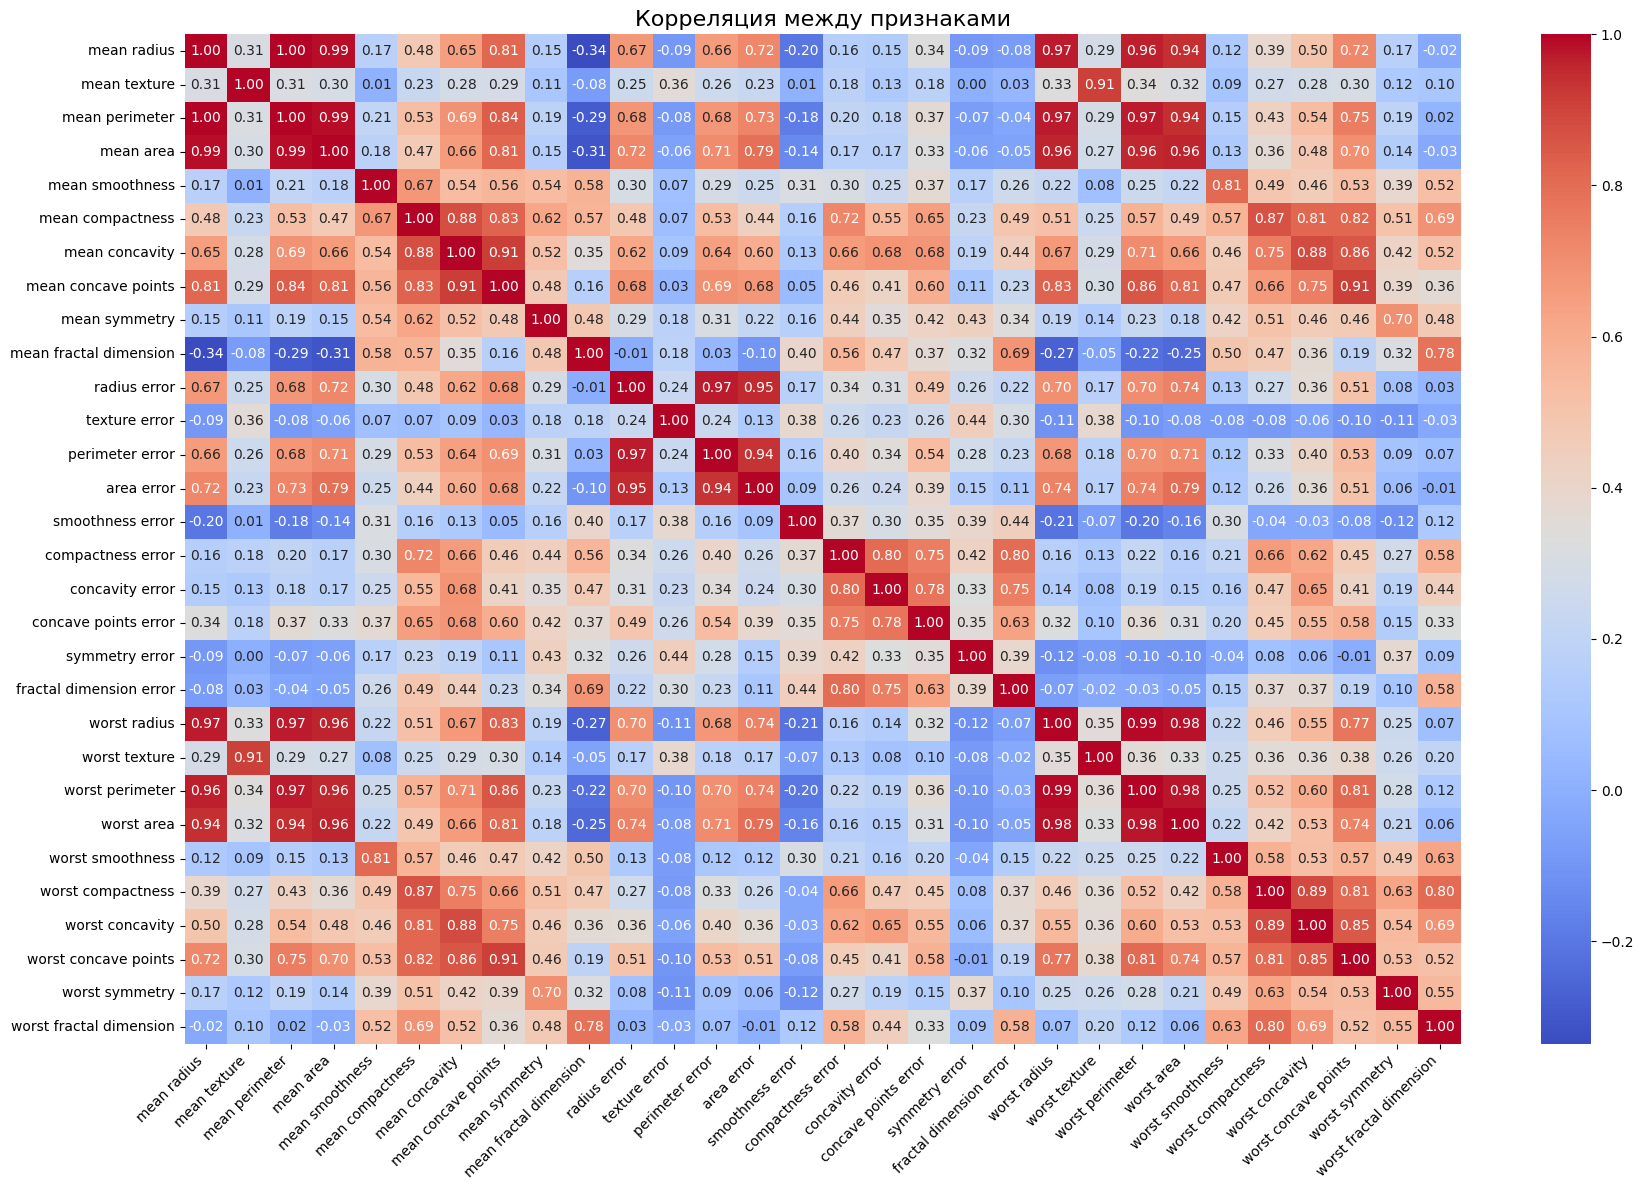

NameError: name 'correlation_matrix' is not defined

In [14]:
# Загрузка данных
breast_cancer_data = load_breast_cancer(as_frame = True)
data = breast_cancer_data.data # Признаки (характеристики опухоли)
labels = breast_cancer_data.target # Метки классов (доброкачественная или злокачественная опухоль)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 42)

# Обучение модели на полном наборе признаков
model_full = GaussianNB()
model_full.fit(X_train, y_train)
y_pred_full = model_full.predict(X_test)

# Оценка точности полной модели
accuracy_full = accuracy_score(y_test, y_pred_full)
print(f"Точность модели на полном наборе признаков: {accuracy_full * 100:.2f}%")

# Отчет о классификации для полной модели
print("Отчет о классификации для полной модели:")
print(classification_report(y_test, y_pred_full))

# Матрица ошибок
conf_matrix_full = confusion_matrix(y_test, y_pred_full)
sns.heatmap(
    conf_matrix_full, annot = True, fmt = "d", cmap = "Blues",
    xticklabels = ["Доброкачественная", "Злокачественная"],
    yticklabels = ["Доброкачественная", "Злокачественная"]
)
plt.title("Матрица ошибок (полная модель)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.show()

# Дополнительные визуализации для лучшего понимания данных
# Визуализация корреляции между признаками в тренировочных данных
plt.figure(figsize = (18, 12)) # Увеличение размера графика
sns.heatmap(
    X_train.corr(), # Использование метода .corr() для вычисления корреляции
    annot = True, # Отображение значений внутри ячеек
    fmt = ".2f", # Формат значений
    cmap = "coolwarm", # Цветовая схема
    cbar = True, # Добавление цветовой шкалы
    xticklabels = X_train.columns, # Подписи по оси X
    yticklabels = X_train.columns # Подписи по оси Y
)
plt.title("Корреляция между признаками", fontsize = 16)
plt.xticks(rotation = 45, ha = "right", fontsize = 10) # Поворот подписей для лучшей читаемости
plt.yticks(fontsize = 10)
plt.tight_layout() # Подгонка элементов графика
plt.show()

# Удаление высоко коррелированных признаков (порог > 0.9)
threshold = 0.9
high_corr_features = [
    feature
    for feature in correlation_matrix.columns
    for other_feature in correlation_matrix.columns
    if feature != other_feature and abs(correlation_matrix.loc[feature, other_feature]) > threshold
]
print("Признаки с высокой корреляцией (будут исключены):", set(high_corr_features))

# Исключение выбранных признаков
X_train_reduced = X_train.drop(columns = set(high_corr_features))
X_test_reduced = X_test.drop(columns = set(high_corr_features))

# Обучение модели на уменьшенном наборе признаков
model_reduced = GaussianNB()
model_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = model_reduced.predict(X_test_reduced)

# Оценка точности модели после исключения признаков
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
print(f"Точность модели после исключения признаков: {accuracy_reduced * 100:.2f}%")

# Отчет о классификации для модели с уменьшенным набором признаков
print("Отчет о классификации для модели с уменьшенным набором признаков:")
print(classification_report(y_test, y_pred_reduced))

# Матрица ошибок для модели с уменьшенным набором признаков
conf_matrix_reduced = confusion_matrix(y_test, y_pred_reduced)
sns.heatmap(
    conf_matrix_reduced, annot = True, fmt = "d", cmap = "Blues",
    xticklabels = ["Доброкачественная", "Злокачественная"],
    yticklabels = ["Доброкачественная", "Злокачественная"]
)
plt.title("Матрица ошибок (уменьшенный набор признаков)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.show()

# Применение метода Монте-Карло для оценки параметров
# Генерация выборок для полной модели
n_samples = 10000
likelihoods_full = []
theta_samples_full = []

for _ in range(n_samples):
    theta_sample = np.random.randn(X_train.shape[1]) # Генерация случайных параметров
    y_pred_sample = np.dot(X_train, theta_sample) # Предсказания на основе случайных параметров
    likelihood = -np.sum((y_train - y_pred_sample) ** 2) # Оценка правдоподобия
    theta_samples_full.append(theta_sample)
    likelihoods_full.append(likelihood)

theta_samples_full = np.array(theta_samples_full)

# Генерация выборок для модели с уменьшенным набором признаков
likelihoods_reduced = []
theta_samples_reduced = []

for _ in range(n_samples):
    theta_sample = np.random.randn(X_train_reduced.shape[1])
    y_pred_sample = np.dot(X_train_reduced, theta_sample)
    likelihood = -np.sum((y_train - y_pred_sample) ** 2)
    theta_samples_reduced.append(theta_sample)
    likelihoods_reduced.append(likelihood)

theta_samples_reduced = np.array(theta_samples_reduced)

# Визуализация апостериорного распределения первого параметра
plt.figure(figsize = (10, 6))
plt.hist(
    theta_samples_full[:, 0], bins = 50, color = "blue", edgecolor = "black", alpha = 0.7, label = "Полная модель"
)
plt.hist(
    theta_samples_reduced[:, 0], bins = 50, color = "red", edgecolor = "black", alpha = 0.7, label = "Уменьшенный набор"
)
plt.title("Сравнение апостериорного распределения $\\theta_0$")
plt.xlabel("$\\theta_0$")
plt.ylabel("Частота")
plt.legend()
plt.show()

# Сравнение точности моделей
print("Точность полной модели:", f"{accuracy_full * 100:.2f}%")
print("Точность модели с уменьшенным набором признаков:", f"{accuracy_reduced * 100:.2f}%")

**Объяснение уменьшения точности модели при уменьшении набора признаков.** Признаки — это характеристики данных, которые помогают модели делать предсказания. Например, в задаче классификации раковых опухолей признаки могут включать такие данные, как размер опухоли, её форма и текстура.

- Обучены 2 модели:
    - **Полная модель**, которая использует все доступные признаки
    - **Модель с уменьшенным набором признаков**, где исключены признаки, сильно коррелирующие друг с другом (по их значению корреляции)

Результаты экспериментов показали, что точность модели с уменьшенным набором признаков значительно ниже. Почему так происходит?

**Результаты**

- Точность моделей:
    - **Полная модель** с точностью 97.37%
    - **Модель с уменьшенным набором признаков** с точностью 83.33%

**Причины уменьшения точности**

1. **Потеря информации.** При исключении признаков, в любом случае теряется часть информации, которая может помочь модели лучше предсказать результат. Признаки, которые были удалены, содержали полезную информацию, даже при условии, что они сильно скоррелированы между собой
2. **Корреляция признаков.** Высокая корреляция между признаками означает, что два или больше признаков несут схожую информацию. Но, каждый из этих признаков явно вносит небольшие, но важные различия в решение модели. Удаление этих признаков привело, к уменьшению способности модели распознавать скрытые закономерности в данных
3. **Переобучение (Overfitting).** Модели, использующие все признаки, могут `переобучаться`, иными словами подстраиваться под обучающие данные, но плохо работать на новых, невиданных данных. Исключение признаков может помочь избежать переобучения, но также может снизить точность на тестовых данных
4. **Недостаток оптимизации модели.** Модель, обученная на меньшем наборе признаков, может не быть оптимизирована для использования оставшихся признаков. При таком подходе модель может не успеть правильно обучиться на новых данных

**Математика**

При уменьшении числа признаков в любом случае изменяется пространство признаков, в котором работает модель. Это можно представить как изменение размерности пространства. Предположим, что у нас есть модель, которая пытается найти гиперплоскость (или границу), разделяющую два класса

Допустим, у нас есть данные с признаками $x_1, x_2, ..., x_n$, где $n$ — это количество признаков. Модель пытается найти параметры $\theta = [\theta_1, \theta_2, ..., \theta_n]$, которые минимизируют ошибку предсказания

В случае с полной моделью (с использованием всех признаков) ошибка модели может быть выражена как:

$$
E = \sum_{i=1}^{m} (y_i - \hat{y_i})^2
$$

где:
- $m$ — количество примеров в обучающей выборке
- $y_i$ — истинное значение
- $\hat{y_i}$ — предсказанное значение модели

При уменьшении признаков количество параметров $\theta$ также уменьшается, что изменяет пространство решений. В итоге теряется часть информации, которая могла бы улучшить точность, и таким образом ошибка увеличивается. Формула ошибки для модели с уменьшенным набором признаков:

$$
E_{\text{reduced}} = \sum_{i=1}^{m} (y_i - \hat{y_i})^2 \quad \text{где количество признаков теперь меньше.}
$$

**Метод Монте-Карло для оценки параметров**

В данном примере использовался метод Монте-Карло для оценки параметров моделей. Метод заключается в том, чтобы генерировать случайные выборки и наблюдать за их поведением. Для полной модели и модели с уменьшенным набором признаков были сгенерированы выборки параметров $\theta$ и рассчитывалось правдоподобие данных

Для каждой выборки параметров было вычислено правдоподобие следующим образом:

$$
L(\theta) = -\sum_{i=1}^{m} (y_i - X_i \times \theta)^2
$$

где:
- $X_i$ — это признаки
- $\theta$ — параметры модели

In [ ]:
# Загрузка данных
breast_cancer_data = load_breast_cancer(as_frame = True)
data = breast_cancer_data.data # Признаки (характеристики опухоли)
labels = breast_cancer_data.target # Метки классов (доброкачественная или злокачественная опухоль)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 42)

# Обучение модели на полном наборе признаков
model_full = GaussianNB()
model_full.fit(X_train, y_train)
y_pred_full = model_full.predict(X_test)

# Оценка точности полной модели
accuracy_full = accuracy_score(y_test, y_pred_full)
print(f"Точность модели на полном наборе признаков: {accuracy_full * 100:.2f}%")

# Отчет о классификации для полной модели
print("Отчет о классификации для полной модели:")
print(classification_report(y_test, y_pred_full))

# Матрица ошибок
conf_matrix_full = confusion_matrix(y_test, y_pred_full)
sns.heatmap(
    conf_matrix_full, annot = True, fmt = "d", cmap = "Blues",
    xticklabels = ["Доброкачественная", "Злокачественная"],
    yticklabels = ["Доброкачественная", "Злокачественная"]
)
plt.title("Матрица ошибок (полная модель)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.show()

# Дополнительные визуализации для лучшего понимания данных
# Визуализация корреляции между признаками в тренировочных данных
plt.figure(figsize = (18, 12)) # Увеличение размера графика
sns.heatmap(
    X_train.corr(), # Использование метода .corr() для вычисления корреляции
    annot = True, # Отображение значений внутри ячеек
    fmt = ".2f", # Формат значений
    cmap = "coolwarm", # Цветовая схема
    cbar = True, # Добавление цветовой шкалы
    xticklabels = X_train.columns, # Подписи по оси X
    yticklabels = X_train.columns # Подписи по оси Y
)
plt.title("Корреляция между признаками", fontsize = 16)
plt.xticks(rotation = 45, ha = "right", fontsize = 10) # Поворот подписей для лучшей читаемости
plt.yticks(fontsize = 10)
plt.tight_layout() # Подгонка элементов графика
plt.show()

# Удаление признаков по названию
features_to_remove = ["mean radius", "worst fractal dimension", "worst symmetry"]

# Визуализация корреляции между удаленными признаками
correlation_matrix = X_train[features_to_remove].corr()
plt.figure(figsize = (6, 4))
sns.heatmap(
    correlation_matrix, annot = True, fmt = ".2f", cmap = "coolwarm", cbar = True,
    xticklabels = features_to_remove, yticklabels = features_to_remove
)
plt.title("Корреляция между удаленными признаками")
plt.show()

# Исключение выбранных признаков
X_train_reduced = X_train.drop(columns = set(features_to_remove))
X_test_reduced = X_test.drop(columns = set(features_to_remove))

# Обучение модели на уменьшенном наборе признаков
model_reduced = GaussianNB()
model_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = model_reduced.predict(X_test_reduced)

# Оценка точности модели после исключения признаков
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
print(f"Точность модели после исключения признаков: {accuracy_reduced * 100:.2f}%")

# Отчет о классификации для модели с уменьшенным набором признаков
print("Отчет о классификации для модели с уменьшенным набором признаков:")
print(classification_report(y_test, y_pred_reduced))

# Матрица ошибок для модели с уменьшенным набором признаков
conf_matrix_reduced = confusion_matrix(y_test, y_pred_reduced)
sns.heatmap(
    conf_matrix_reduced, annot = True, fmt = "d", cmap = "Blues",
    xticklabels = ["Доброкачественная", "Злокачественная"],
    yticklabels = ["Доброкачественная", "Злокачественная"]
)
plt.title("Матрица ошибок (уменьшенный набор признаков)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.show()

# Применение метода Монте-Карло для оценки параметров
# Генерация выборок для полной модели
n_samples = 10000
likelihoods_full = []
theta_samples_full = []

for _ in range(n_samples):
    theta_sample = np.random.randn(X_train.shape[1]) # Генерация случайных параметров
    y_pred_sample = np.dot(X_train, theta_sample) # Предсказания на основе случайных параметров
    likelihood = -np.sum((y_train - y_pred_sample) ** 2) # Оценка правдоподобия
    theta_samples_full.append(theta_sample)
    likelihoods_full.append(likelihood)

theta_samples_full = np.array(theta_samples_full)

# Генерация выборок для модели с уменьшенным набором признаков
likelihoods_reduced = []
theta_samples_reduced = []

for _ in range(n_samples):
    theta_sample = np.random.randn(X_train_reduced.shape[1])
    y_pred_sample = np.dot(X_train_reduced, theta_sample)
    likelihood = -np.sum((y_train - y_pred_sample) ** 2)
    theta_samples_reduced.append(theta_sample)
    likelihoods_reduced.append(likelihood)

theta_samples_reduced = np.array(theta_samples_reduced)

# Визуализация апостериорного распределения первого параметра
plt.figure(figsize = (10, 6))
plt.hist(
    theta_samples_full[:, 0], bins = 50, color = "blue", edgecolor = "black", alpha = 0.7, label = "Полная модель"
)
plt.hist(
    theta_samples_reduced[:, 0], bins = 50, color = "red", edgecolor = "black", alpha = 0.7, label = "Уменьшенный набор"
)
plt.title("Сравнение апостериорного распределения $\\theta_0$")
plt.xlabel("$\\theta_0$")
plt.ylabel("Частота")
plt.legend()
plt.show()

# Сравнение точности моделей
print("Точность полной модели:", f"{accuracy_full * 100:.2f}%")
print("Точность модели с уменьшенным набором признаков:", f"{accuracy_reduced * 100:.2f}%")

In [ ]:
# Загрузка данных
breast_cancer_data = load_breast_cancer(as_frame = True)
data = breast_cancer_data.data # Признаки
labels = breast_cancer_data.target # Метки классов

# Разделение на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 42)

# Стандартизация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Список моделей
models = [
    ("Логистическая регрессия", LogisticRegression(max_iter = 10000)),
    ("SVM", SVC()),
    ("Случайный лес", RandomForestClassifier()),
    ("Градиентный бустинг", GradientBoostingClassifier()),
    ("Наивный байес", GaussianNB()),
    ("KNN", KNeighborsClassifier())
]

# Функция для бутстрэппинга
def bootstrap_evaluation(model, X_train, y_train, n_iterations = 10):
    scores = []
    for _ in range(n_iterations):
        # Создание случайной подвыборки данных
        X_resampled, y_resampled = resample(X_train, y_train, random_state = 42)

        # Обучение модели на подвыборке
        model.fit(X_resampled, y_resampled)

        # Оценка модели на тестовых данных
        score = model.score(X_test_scaled, y_test)
        scores.append(score)

    # Возвращаем среднюю производительность и стандартное отклонение
    return np.mean(scores), np.std(scores)

# Функция для случайного поиска гиперпараметров
def random_search_evaluation(model, X_train, y_train):
    if isinstance(model, SVC):
        param_dist = {
            "C": uniform(0.1, 10), # Случайные значения для C
            "gamma": uniform(0.001, 0.1), # Случайные значения для gamma
            "kernel": ["linear", "poly", "rbf"] # Случайный выбор ядер
        }
        random_search = RandomizedSearchCV(model, param_distributions = param_dist, n_iter = 100, random_state = 42, n_jobs = -1, cv = 5)
        random_search.fit(X_train, y_train)
        return random_search.best_params_, random_search.best_score_
    else:
        return None, None

results = {} # Словарь для хранения результатов

# Обучение и оценка моделей
for model_name, model in models:
    # Стандартная оценка
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[model_name] = {
        "Classification Report": classification_report(y_test, y_pred, output_dict=True),
        "Bootstrap Mean Accuracy": None,
        "Bootstrap Std Accuracy": None,
        "Random Search Best Params": None,
        "Random Search Best Score": None
    }

    # Оценка методом Монте-Карло (бутстрэппинг)
    mean_score, std_score = bootstrap_evaluation(model, X_train_scaled, y_train)
    results[model_name]["Bootstrap Mean Accuracy"] = mean_score
    results[model_name]["Bootstrap Std Accuracy"] = std_score

    # Оценка методом случайного поиска гиперпараметров
    best_params, best_score = random_search_evaluation(model, X_train_scaled, y_train)
    results[model_name]["Random Search Best Params"] = best_params
    results[model_name]["Random Search Best Score"] = best_score

# Печать результатов для каждой модели
for model_name, report in results.items():
    print(f"Модель: {model_name}")

    # Вывод classification_report в виде таблицы
    print("Метрики классификации для каждой категории:")
    classification_df = pd.DataFrame(report["Classification Report"]).transpose()
    print(classification_df)

    # Добавление информации о бутстрэппинге
    print(f"\nСредняя точность бутстрэппинга: {report['Bootstrap Mean Accuracy']:.4f}")
    print(f"Стандартное отклонение бутстрэппинга: {report['Bootstrap Std Accuracy']:.4f}")

    # Проверка и вывод результатов случайного поиска
    if report["Random Search Best Params"] is not None:
        print(f"Лучшие параметры случайного поиска: {report['Random Search Best Params']}")
    else:
        print("Лучшие параметры случайного поиска: Не применялся")

    if report["Random Search Best Score"] is not None:
        print(f"Лучший результат случайного поиска: {report['Random Search Best Score']:.4f}")
    else:
        print("Лучший результат случайного поиска: Не применялся")

    # Разделитель для читаемости
    print("\n" + "="*50 + "\n")

# Сводка результатов
summary_results = []

for model_name, report in results.items():
    summary_results.append({
        "Модель": model_name,
        "Средняя точность бутстрэппинга": report["Bootstrap Mean Accuracy"],
        "Стандартное отклонение бутстрэппинга": report["Bootstrap Std Accuracy"],
        "Лучший результат случайного поиска": report["Random Search Best Score"] if report["Random Search Best Score"] is not None else "Не применялся",
        "Лучшие параметры случайного поиска": str(report["Random Search Best Params"]) if report["Random Search Best Params"] is not None else "Не применялись"
    })

# Преобразование в DataFrame
summary_df = pd.DataFrame(summary_results)

# Заполнение NaN значения
summary_df["Лучший результат случайного поиска"] = summary_df["Лучший результат случайного поиска"].fillna("Не применялся")
summary_df["Лучшие параметры случайного поиска"] = summary_df["Лучшие параметры случайного поиска"].fillna("Не применялись")

# Дополнительные визуализации для лучшего понимания данных
# Визуализация корреляции между признаками в тренировочных данных
plt.figure(figsize = (18, 12))
sns.heatmap(
    X_train.corr(),
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    cbar = True,
    xticklabels = X_train.columns,
    yticklabels = X_train.columns
)
plt.title("Корреляция между признаками", fontsize = 16)
plt.xticks(rotation = 45, ha = "right", fontsize = 10)
plt.yticks(fontsize = 10)
plt.tight_layout()
plt.show()

# Уменьшение размерности с использованием PCA
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Визуализация данных после PCA
plt.figure(figsize = (10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c = y_train, cmap = "coolwarm")
plt.title("PCA - Тренировочные данные", fontsize = 16)
plt.xlabel("Главная компонента 1", fontsize = 12)
plt.ylabel("Главная компонента 2", fontsize = 12)
plt.colorbar(label = "Класс")
plt.tight_layout()
plt.show()

# Уменьшение размерности с использованием t-SNE
tsne = TSNE(n_components = 2)
X_train_tsne = tsne.fit_transform(X_train_scaled)

# Визуализация данных после t-SNE
plt.figure(figsize = (10, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c = y_train, cmap = "coolwarm")
plt.title("t-SNE - Тренировочные данные", fontsize = 16)
plt.xlabel("t-SNE Компонента 1", fontsize = 12)
plt.ylabel("t-SNE Компонента 2", fontsize = 12)
plt.colorbar(label = "Класс")
plt.tight_layout()
plt.show()

# Уменьшение размерности с использованием LDA (Linear Discriminant Analysis)
lda = LinearDiscriminantAnalysis(n_components = 1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)

# Визуализация данных после LDA
plt.figure(figsize = (10, 6))
plt.scatter(X_train_lda[:, 0], np.zeros_like(X_train_lda[:, 0]), c = y_train, cmap = "coolwarm")
plt.title("LDA - Тренировочные данные", fontsize = 16)
plt.xlabel("Линейная дискриминантная компонента 1", fontsize = 12)
plt.colorbar(label = "Класс")
plt.tight_layout()
plt.show()


# Печать таблицы с нужным форматированием
print("Сводка результатов:\n")

# Получение лучшей модели (по максимальному значению лучшего результата случайного поиска)
best_model_idx = summary_df["Лучший результат случайного поиска"].apply(lambda x: isinstance(x, (int, float))).idxmax()
best_model = summary_df.loc[best_model_idx]

# Печать информации о лучшей модели
print("\nРезультаты лучшей модели:")
print(f"Модель: {best_model["Модель"]}")
print(f"Средняя точность бутстрэппинга: {best_model["Средняя точность бутстрэппинга"]:.6f}")
print(f"Стандартное отклонение бутстрэппинга: {best_model["Стандартное отклонение бутстрэппинга"]:.6f}")
print(f"Лучший результат случайного поиска: {best_model["Лучший результат случайного поиска"]}")
print(f"Лучшие параметры случайного поиска: {best_model["Лучшие параметры случайного поиска"]}")

summary_df

### Домашнее задание

Выбрать два набора данных (или два других, которые подойдут для задачи классификации на основе множества признаков):
1. **Pima Indians Diabetes Database**
2. **Adult Income Dataset (Census Income)**
3. **Wine Quality Dataset**
4. **Heart Disease Dataset**
5. **Employee Attrition Dataset**

#### Задание

1. **Загрузить данные**
    - Использовать pandas для загрузки выбранных наборов данных
    - Изучить структуру данных и типы признаков (например, числовые или категориальные)
2. **Предобработать данные**
    - Обработать пропущенные значения (если они есть)
    - Преобразовать категориальные признаки в числовые
    - Разделите данные на признаки (X) и метки (y) - если необходимо
3. **Разделить данные на тренировочные и тестовые**
    - Использовать `train_test_split` (или аналоги) для разделения данных на тренировочную и тестовую выборки (N% для тренировки, N% для тестирования)
4. **Масштабировать данные**
    - Стандартизировать данные с помощью `StandardScaler` для нормализации признаков (при необходимости)
5. **Обучить модели (для каждой модели выполнить обучение на всех признаках и произвести оценку на тестовой выборке)**
    - Логистическая регрессия
    - SVM (Support Vector Machine)
    - Случайный лес
    - Градиентный бустинг
    - Наивный байес
    - K-Nearest Neighbors (KNN)
6. **Уменьшить размерность (визуализировать результат уменьшения размерности для лучшего понимания данных)**
    - PCA (Principal Component Analysis)
    - t-SNE (t-Distributed Stochastic Neighbor Embedding)
    - LDA (Linear Discriminant Analysis)
7. **Оценить модели с использованием бутстрэппинга**
    - Реализовать метод бутстрэппинга для оценки устойчивости каждой модели. Использовать несколько итераций (например, 100, 250, 500) для оценки точности моделей на случайных подвыборках данных
8. **Произвести случайный поиск гиперпараметров**
    - Использовать `RandomizedSearchCV` для нахождения лучших гиперпараметров для модели SVM (или любой другой модели, по выбору)
    - Оценить производительность модели с подобранными гиперпараметрами
9. **Подготовить отчет**
    - Представить результаты для каждой модели:
        - Классификационный отчет (`classification_report`)
        - Средняя точность и стандартное отклонение для бутстрэппинга
        - Лучшие параметры и лучший результат для случайного поиска
    - Составить итоговую таблицу с результатами всех моделей и методов уменьшения размерности
10. **Выводы**
    - Какие модели показали лучшие результаты?
    - Как методы уменьшения размерности повлияли на результаты?
    - Какие гиперпараметры оказались наилучшими для выбранной модели?
**Дополнительно (по желанию)**
    - Визуализировать результаты классификации для каждого класса
    - Создать тепловую карту для корреляции между признаками
    - Оценить время, необходимое для обучения и оценки моделей
    - Оценить как уменьшение размерности признаков влияет на объем сохраненной модели

In [19]:
!pip install scipy

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import uniform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

In [56]:
pima = pd.read_csv('/content/diabetes.csv')
wine = pd.read_csv('/content/WineQT.csv')

In [43]:
pima.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [44]:
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [45]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [46]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [57]:
pima.fillna(pima.median(), inplace=True)
X1 = pima.drop('Outcome', axis=1)
y1 = pima['Outcome']

wine['quality'] = (wine['quality'] >= 6).astype(int)
X2 = wine.drop('quality', axis=1)
y2 = wine['quality']


In [55]:
y1

,Outcome
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
763,1.0
764,1.0
765,1.0
766,1.0


In [60]:
def run_pipeline(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)
    models = [
        ('LR', LogisticRegression(max_iter=5000)),
        ('SVM', SVC()),
        ('RF', RandomForestClassifier()),
        ('GB', GradientBoostingClassifier()),
        ('NB', GaussianNB()),
        ('KNN', KNeighborsClassifier())
    ]
    reports = {}
    for name, mdl in models:
        mdl.fit(X_train_s, y_train)
        y_pred = mdl.predict(X_test_s)
        rep = classification_report(y_test, y_pred, output_dict=True)
        reports[name] = {
            'report': rep,
            'acc': accuracy_score(y_test, y_pred)
        }
    return X_train_s, X_test_s, y_train, y_test, reports


In [61]:
X1_tr, X1_te, y1_tr, y1_te, rep1 = run_pipeline(X1, y1)
X2_tr, X2_te, y2_tr, y2_te, rep2 = run_pipeline(X2, y2)

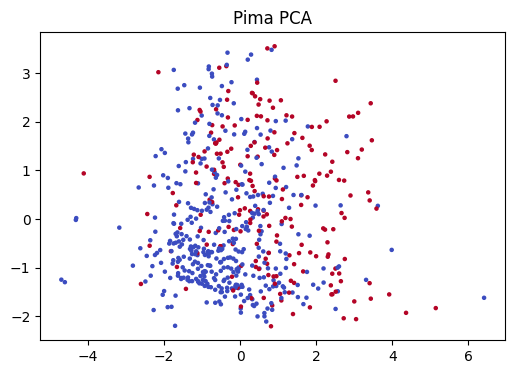

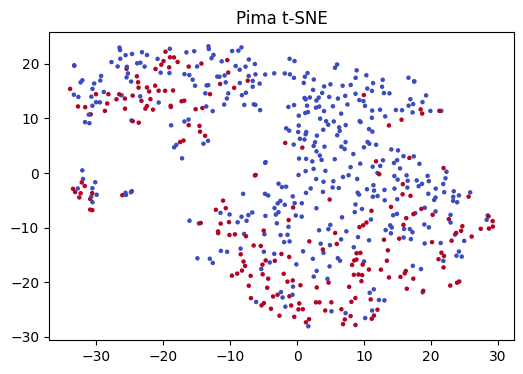

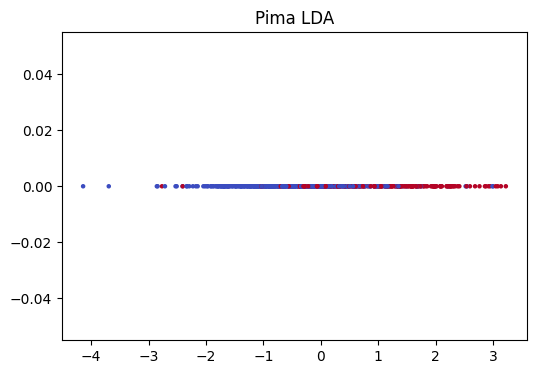

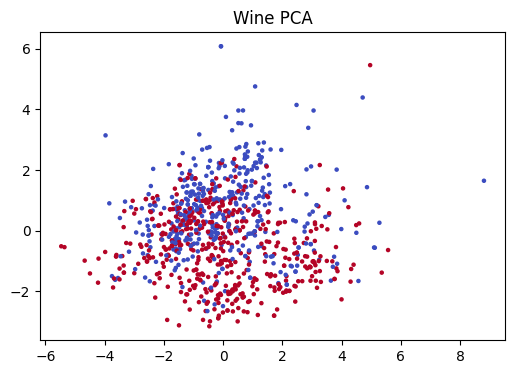

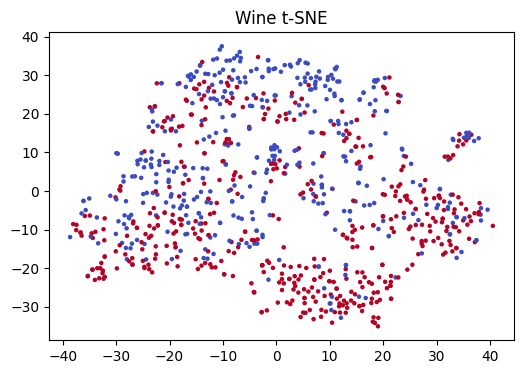

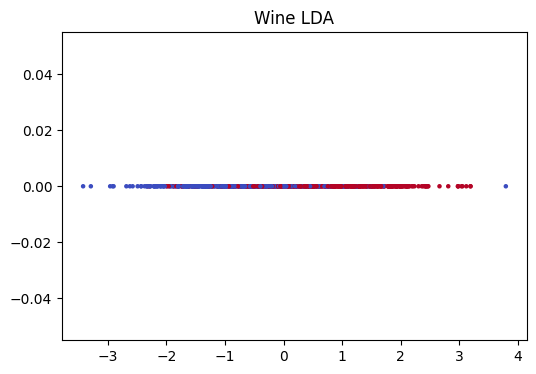

In [62]:
def plot_dr(X, y, title):
    for mdl, name in [(PCA(n_components=2), 'PCA'), (TSNE(n_components=2, random_state=42), 't-SNE'), (LinearDiscriminantAnalysis(n_components=1), 'LDA')]:
        Z = mdl.fit_transform(X, y) if name!='t-SNE' else mdl.fit_transform(X)
        plt.figure(figsize=(6,4))
        plt.scatter(Z[:,0], Z[:,1] if Z.shape[1]>1 else np.zeros(len(Z)), c=y, cmap='coolwarm', s=5)
        plt.title(f'{title} {name}')
        plt.show()

plot_dr(X1_tr, y1_tr, 'Pima')
plot_dr(X2_tr, y2_tr, 'Wine')


In [63]:
def bootstrap_eval(model, X_train, y_train, X_test, y_test, n_iter=100):
    scores = []
    for i in range(n_iter):
        X_r, y_r = resample(X_train, y_train, random_state=i)
        model.fit(X_r, y_r)
        scores.append(model.score(X_test, y_test))
    return np.mean(scores), np.std(scores)

bs = {}
for name, mdl in [
    ('LR', LogisticRegression(max_iter=5000)),
    ('SVM', SVC()),
    ('RF', RandomForestClassifier()),
    ('GB',GradientBoostingClassifier()),
    ('NB', GaussianNB()),
    ('KNN', KNeighborsClassifier())
    ]:
    m = mdl
    mean1, std1 = bootstrap_eval(m, X1_tr, y1_tr, X1_te, y1_te)
    mean2, std2 = bootstrap_eval(m, X2_tr, y2_tr, X2_te, y2_te)
    bs.setdefault('Pima', {})[name] = (mean1, std1)
    bs.setdefault('Wine', {})[name] = (mean2, std2)


In [64]:
param_dist = {'C': uniform(0.1,10), 'gamma': uniform(0.001,0.1), 'kernel': ['rbf','linear']}
rs1 = RandomizedSearchCV(SVC(), param_dist, n_iter=50, cv=5, random_state=42)
rs1.fit(X1_tr, y1_tr)
rs2 = RandomizedSearchCV(SVC(), param_dist, n_iter=50, cv=5, random_state=42)
rs2.fit(X2_tr, y2_tr)


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b85045ab590>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b85055013d0>,
                                        'kernel': ['rbf', 'linear']},
                   random_state=42)

In [65]:
rows = []
for ds, rep, b in [('Pima', rep1, bs['Pima']),('Wine', rep2, bs['Wine'])]:
    for mdl in rep:
        cr = rep[mdl]['report']
        rows.append({
            'Dataset': ds,
            'Model': mdl,
            'Accuracy': rep[mdl]['acc'],
            'Boot Mean': b[mdl][0],
            'Boot Std': b[mdl][1],
            'RS Best Score': (rs1.best_score_ if ds=='Pima' else rs2.best_score_),
            'RS Best Params': (rs1.best_params_ if ds=='Pima' else rs2.best_params_)
        })
summary = pd.DataFrame(rows)
print(summary)


   Dataset Model  Accuracy  Boot Mean  Boot Std  RS Best Score  \
0     Pima    LR  0.714286   0.723701  0.011702       0.781807   
1     Pima   SVM  0.753247   0.724545  0.020884       0.781807   
2     Pima    RF  0.753247   0.735390  0.021544       0.781807   
3     Pima    GB  0.753247   0.743506  0.018378       0.781807   
4     Pima    NB  0.707792   0.702532  0.014912       0.781807   
5     Pima   KNN  0.701299   0.696299  0.028123       0.781807   
6     Wine    LR  0.777293   0.764541  0.010619       0.757089   
7     Wine   SVM  0.786026   0.750742  0.016440       0.757089   
8     Wine    RF  0.812227   0.778035  0.016468       0.757089   
9     Wine    GB  0.781659   0.760262  0.020121       0.757089   
10    Wine    NB  0.755459   0.737467  0.017773       0.757089   
11    Wine   KNN  0.720524   0.683493  0.026551       0.757089   

                                       RS Best Params  
0   {'C': 3.4370861113902182, 'gamma': 0.015286681...  
1   {'C': 3.4370861113902182,

In [66]:
print("Лучшие модели по RS-счёту:\n", summary.loc[summary.groupby('Dataset')['RS Best Score'].idxmax()])


Лучшие модели по RS-счёту:
   Dataset Model  Accuracy  Boot Mean  Boot Std  RS Best Score  \
0    Pima    LR  0.714286   0.723701  0.011702       0.781807   
6    Wine    LR  0.777293   0.764541  0.010619       0.757089   

                                      RS Best Params  
0  {'C': 3.4370861113902182, 'gamma': 0.015286681...  
6  {'C': 1.295942459383017, 'gamma': 0.0723244787...  


## Выводы
1. Лучше всех показал себя Random Forest. Возможно, это в силу того, что этот алгоритм считается самым универсальным в ML, и он не требует настолько широкого подбора гиперпараметров, которого требуют другие алгоритмы.
2. Из графиков видно, что методы понижения размерности не смогли предоставить разбиение, необходимое для построения классификатора, который способен хорошо разделить классы
3. Лучшие гиперпараметры выведены выше  